# Results !

# Data import

We first import all the data needed for this analysis

In [1]:
%reset -f
import re
import json
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from disaggregator import data, spatial
from disaggregator.config import get_config
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

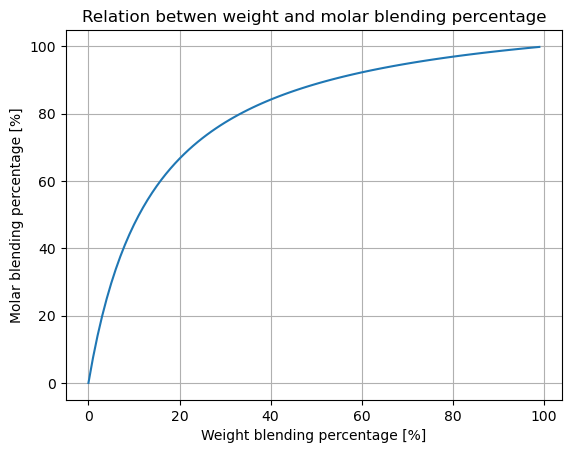

In [15]:
mH2 = 2
mCH4= 16

b = np.arange(1e-16, 1, 1/100)
c = 1 / (1 + (1-b)*mH2/mCH4/b)
plt.plot(100 * b, 100 * c)

plt.xlabel("Weight blending percentage [%]")
plt.ylabel("Molar blending percentage [%]")
plt.title("Relation betwen weight and molar blending percentage")

plt.grid()

plt.savefig("project_data/out/Images/04_02_blending.png", transparent = True, dpi = 300, bbox_inches='tight')

Import the data from the optimization notebook

In [24]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

In [25]:
with open("project_data/out/lengths.json", 'r') as file:
    pipesLengths = json.load(file)

In [26]:
with open("project_data/out/pipesDestination.json", 'r') as file:
    pipesDestination = pd.DataFrame.from_dict(json.load(file))

In [27]:
with open("project_data/out/finalPipes.json", 'r') as file:
    finalPipes = pd.DataFrame.from_dict(json.load(file))

In [28]:
solar_irr = gpd.read_file("project_data/in/WeatherData/weatherData_2022.geojson").drop(columns = ["geometry", "std_irr"])
solar_irr["mean_irr"] = solar_irr["mean_irr"].apply(lambda x: json.loads(x)) # Transform the list from str to list. It is stored as a string

solar_irr.head()

,nuts3,mean_irr
0,DE111,"[12.947962085308056, 28.988862559241703, 76.04..."
1,DE112,"[14.930658105939004, 29.198876404494385, 74.24..."
2,DE113,"[14.731011058451816, 29.061595576619276, 78.27..."
3,DE114,"[14.036507936507936, 26.150539682539684, 78.67..."
4,DE115,"[10.229955817378498, 26.00743740795287, 74.579..."


Compute smol things

In [29]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

## Preparing the DataFrame for easy data handling later

Each row considers a different case of a single number of plants $n$, blending percentage $b$, reference month $m$ and minimum percentage threshold $perc$.

| **perc** | **m** | **b** | **n** |       **locations**      |                       **servings**                      |          **OPEX**          |       **CAPEX**      |   **capacity**   | **production_1** | **...** | **production_12** |      **Area**     |
|:--------:|:-----:|:-----:|:-----:|:-----------------------:|:-------------------------------------------------------:|:--------------------------:|:--------------------:|:----------------:|:----------------:|:-------:|:-----------------:|:-----------------:|
|   0.75   |   3   |  0.1  |   20  | ['DE111', ..., 'DE300'] | [['DE112', ..., 'DE213'], ..., ['DE404', ..., 'DE239']] | [249233.23, ..., 23485.75] | [487054, ..., 95574] | [8574, ..., 543] | [7483, ..., 543] |   ...   |  [8233, ..., 501] | [15425, ..., 853] |

In [30]:
rows_list = []
toGet = ["locations", "OPEX", "CAPEX", "capacity", "servings", "Area"]

for perc in [0.3, 0.4, 0.5]:
    for m in range(1, 13):
        for b in [0.03, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]:
            try:
                with open(f"project_data/out/reducedDemand/optimalPlaces_reduced_{b}_{m:02}_{perc}_minTOTEX.json") as file:
                    optimalPlaces = json.load(file)

                    for i, n in enumerate(list(np.arange(20, 41))):
                        dictionary = {thing: optimalPlaces[thing][i] for thing in toGet}
                        dictionary['perc'] = perc
                        dictionary['m'] = m
                        dictionary['b'] = b
                        dictionary['n'] = n

                        # Treat the production to have one line per month
                        for t in range(1, 13):
                            dictionary[f'production {t}'] = optimalPlaces["production"][i][t-1]

                        rows_list.append(dictionary)
                        
            except FileNotFoundError:
                print(f"File not found perc={perc}, m={m:02} and b={b}. Skipping...")
                continue

# Array to dataframe and reorder the columns
df_plants = pd.DataFrame(rows_list)
df_plants = df_plants[['perc', 'b', 'm', 'n', 'locations', 'OPEX', 'CAPEX', 'capacity', 'production 1', 'production 2', 'production 3', 'production 4', 'production 5', 'production 6', 'production 7', 'production 8', 'production 9', 'production 10', 'production 11', 'production 12', 'servings', 'Area']]

# Computing the hydrogen demand

Here we compute the hydrogen demand in the same way as it is done in the model. Since it is the exact same way I should create a function to do it behind the scenes... hehe.

## First we bring the industry

Even though at the end I didn't end up using it :(

In [31]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open(f"project_data/in/Industries/{file}", 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

i = 0
for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue

        if (i == 1 and element["Product"] != "Crude"): # Keep only the crude production
            toDelete.append(element)
            continue

        if (i == 2 and element["Process"] == "Electric"): # Keep only high furnaces
            toDelete.append(element)
            continue

        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]

        temp.append(Point(element["geometry"][0], element["geometry"][1]))
        
    i += 1
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

# The production is in ton_product/yr so we must transform them into kgH2/d
# We have : ton -> kg (* 1000) , ratio H2/product (x / y) , year -> day (/ 365)

aPoints["consumption"] = [(int(a["Production"]) * 1000 * 176.14 / 1000 / 365) for a in amonia]          # In kgH2 / d
rPoints["consumption"] = [(int(r["Production"]) * 1000 * 1.02 / 227.69 / 365) for r in refineries]      # In kgH2 / d
sPoints["consumption"] = [(int(s["Production"]) * 1000 * 0.97 * 54.171367 / 1000 / 365) for s in steel] # In kgH2 / d

# Find the NUTS3 district where they lay in
aPoints = gpd.sjoin(aPoints, nuts).drop(columns = ['geometry'])
rPoints = gpd.sjoin(rPoints, nuts).drop(columns = ['geometry'])
sPoints = gpd.sjoin(sPoints, nuts).drop(columns = ['geometry'])

# Re-structure the dataframes
aPoints = aPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})
rPoints = rPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})
sPoints = sPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})

# Distribute the production through out the year
daysMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for t in range(1, 13):
    aPoints[f'value {t}'] = aPoints['consumption'] * daysMonth[t - 1] # kgH2 / month_t
    rPoints[f'value {t}'] = rPoints['consumption'] * daysMonth[t - 1] # kgH2 / month_t
    sPoints[f'value {t}'] = sPoints['consumption'] * daysMonth[t - 1] # kgH2 / month_t

aPoints.drop(columns = ['consumption'], inplace=True)
rPoints.drop(columns = ['consumption'], inplace=True)
sPoints.drop(columns = ['consumption'], inplace=True)

## Residential demand

Now we bring the residential demand. It is here where we apply the criteria and the monthly profile.

In [32]:
# =========== Household sizes ===========

from disaggregator import data
from disaggregator.config import get_config

df = data.database_get('spatial', table_id=14, force_update = False)
df = df.assign(nuts3=lambda x: x.id_region.map(data.dict_region_code()),
                    hh_size=lambda x: x.internal_id.str[0].astype(int)) .loc[lambda x: x.hh_size != 0] .pivot_table(values='value', index='nuts3', columns='hh_size',aggfunc='sum')

cfg = get_config()
year = cfg['base_year']
gas_nuts0 = spatial.gas_consumption_HH(year=year)

hh_size = df.copy()

hh_size[3] = hh_size[3] + hh_size[4] + hh_size[5]
hh_size.drop(columns = [4, 5], inplace = True)

HH_dict = {
    1 : '1FH',
    2 : 'TH',
    3 : 'MFH',
    6 : 'MSB'
}

hh_size.rename(columns = HH_dict, inplace = True)

hh_size.reset_index(inplace=True)
hh_size.rename(columns={'index': 'nuts3'}, inplace=True)


# Melting the DataFrame
melted_df = hh_size.melt(id_vars=['nuts3'], var_name='building_type', value_name='value')
melted_df.sort_values(by='nuts3', inplace=True)
melted_df.reset_index(drop=True, inplace=True)

norm_HH = melted_df.copy()
norm_HH["value"] = melted_df["value"] / melted_df["value"].values.sum()
norm_HH["value"] *= gas_nuts0['Cooking']

# =========== Population ===========

# Define multiplication factors
multipliers = {
    '1FH': 1,
    'TH':  1,
    'MFH': 11,
    'MSB': 32
}

pop_df = melted_df.copy()

# Apply multiplications based on building_type
pop_df['multiplier'] = melted_df['building_type'].map(multipliers)
pop_df['value'] = melted_df['value'] * pop_df['multiplier']
pop_df.drop(columns = ["multiplier"], inplace=True)

norm_pop = pop_df.copy()
norm_pop["value"] = pop_df["value"] / pop_df["value"].sum()
norm_pop["value"] *= gas_nuts0['HotWater']

# =========== Living space ===========

df_living_space = spatial.living_space(aggregate=False, year=2018,
                          internal_id=[None, None, 11, 1]).drop(columns = ['heating_system', 'non_empty_building']).replace()

buildingDict = {'2FH' : 'TH',
                'MFH_03_06': 'MFH',
                'MFH_07_12': 'MSB',
                'MFH_13_99': 'MSB'}

df_living_space.replace(buildingDict, inplace=True)

df_living_space = df_living_space.groupby(['nuts3', 'building_type']).mean()

# uniform non-matching vintage sections
new_m2_vintages = {'A_<1900':     'A_<1948',
                   'B_1900-1945': 'A_<1948',
                   'C_1946-1960': 'B_1949-1968',
                   'D_1961-1970': 'B_1949-1968',
                   'E_1971-1980': 'C_1969-1985',
                   'F_1981-1985': 'C_1969-1985',
                   'G_1986-1995': 'D_1986-1995',
                   'H_1996-2000': 'E_1996-2000',
                   'I_2001-2005': 'F_>2000',
                   'J_2006-2011': 'F_>2000',
                   'K_2012': 'F_>2000',
                   'L_2013': 'F_>2000',
                   'M_2014': 'F_>2000',
                   'N_2015': 'F_>2000',
                   'O_2016': 'F_>2000',
                   'P_2017': 'F_>2000',
                   'Q_2018': 'F_>2000',
                   'R_2019': 'F_>2000'}
new_dem_vintages = {'A_<1859':     'A_<1948',
                    'B_1860-1918': 'A_<1948',
                    'C_1919-1948': 'A_<1948',
                    'D_1949-1957': 'B_1949-1968',
                    'E_1958-1968': 'B_1949-1968',
                    'F_1969-1978': 'C_1969-1985',
                    'G_1979-1983': 'C_1969-1985',
                    'H_1984-1994': 'D_1986-1995',
                    'I_1995-2001': 'E_1996-2000',
                    'J_2002-2009': 'F_>2000'}

# Status Quo buildings
df1 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 1])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class != 'A_<1948'])

# df2 = refurbished buildings
df2 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 2])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class == 'A_<1948'])
df_heat_dem = pd.concat([df1, df2])

# FOR HEATING WE HAVE THE FOLLOWING : ['1FH', 'TH', 'MFH', 'MSB']
# FOR LIVING SPACE WE HAVE : ['1FH', '2FH', 'MFH_03_06', 'MFH_07_12', 'MFH_13_99']

df_heat = df_heat_dem
df_heat['building_type'] = df_heat_dem['building_type'].replace(buildingDict, regex=True)

df_heat = df_heat.groupby(['nuts3', 'building_type']).sum() / 1e3 # kWh -> MWh

SH = df_heat.copy()

SH['value'] = 2.161 * df_living_space['value'].multiply(df_heat['value'], fill_value=0)
SH.reset_index(drop=False, inplace=True)

# =========== CONSTANT GAS DEMAND ===========

DHW = pd.merge(norm_HH, norm_pop, on=['nuts3', 'building_type'], suffixes=(' HH', ' pop'))
DHW['value'] = DHW['value HH'] + DHW['value pop']
DHW.drop(columns = ['value HH', 'value pop'], inplace=True)

# =========== BRING THE PROFILES ===========

DHW_profile = pd.read_csv('project_data/in/HeatLoadProfile/DHW_profile.csv', index_col='nuts3')
SH_profile  = pd.read_csv('project_data/in/HeatLoadProfile/SH_profile.csv', index_col='nuts3')

DHW_t = pd.merge(DHW, DHW_profile, on='nuts3')
SH_t  = pd.merge(SH , SH_profile,  on='nuts3')

# Multiply yearly value by the percentage for each period
for period in range(1, 13):
    DHW_t[f'value {period}'] = DHW_t['value'] * DHW_t[f'Period {period}']
    DHW_t.drop(columns = [f'Period {period}'], inplace = True)
    
    SH_t[f'value {period}'] = SH_t['value'] * SH_t[f'Period {period}']
    SH_t.drop(columns = [f'Period {period}'], inplace = True)

DHW_t.drop(columns=['value'], inplace=True)
SH_t.drop(columns=['value'], inplace=True)

# =========== PUTTING IT ALL TOGETHER ===========

nuts_vals = list(nuts.index)

mergedDemand = SH_t.copy() # We start with the Space Heating demand, and then add the hot water and cooking demand

for n in nuts_vals:                       # For each district
    for b in ['1FH', 'TH', 'MFH', 'MSB']: # For each type of building
        for t in range(1, 13):            # For each period
            sh_pos = (SH_t['nuts3'] == n) & (SH_t['building_type'] == b)  # Index of the row with these conditions
            hw_pos = (DHW_t['nuts3'] == n) & (DHW_t['building_type'] == b)
            col_name = f'value {t}'

            # Perform addition and assignment using .loc with boolean indexing
            mergedDemand.loc[sh_pos, col_name] += DHW_t.loc[hw_pos, col_name].values

# =========== Filter the buildings we wish to have ===========

gasMultipliers = {
    '1FH' : 0.071,
    'TH'  : 0.5294,
    'MFH' : 0.7715,
    'MSB' : 1
}

gasDemand1FH = mergedDemand.loc[mergedDemand["building_type"] == "1FH"].copy()
gasDemandTH  = mergedDemand.loc[mergedDemand["building_type"] ==  "TH"].copy()
gasDemandMFH = mergedDemand.loc[mergedDemand["building_type"] == "MFH"].copy()
gasDemandMSB = mergedDemand.loc[mergedDemand["building_type"] == "MSB"].copy()

for t in range(1, 13):
    gasDemand1FH[f'value {t}'] = gasMultipliers["1FH"] * mergedDemand.loc[mergedDemand["building_type"] == "1FH"][f'value {t}']
    gasDemandTH[f'value {t}']  = gasMultipliers["TH"]  * mergedDemand.loc[mergedDemand["building_type"] ==  "TH"][f'value {t}']
    gasDemandMFH[f'value {t}'] = gasMultipliers["MFH"] * mergedDemand.loc[mergedDemand["building_type"] == "MFH"][f'value {t}']
    gasDemandMSB[f'value {t}'] = gasMultipliers["MSB"] * mergedDemand.loc[mergedDemand["building_type"] == "MSB"][f'value {t}']

gasDemand = pd.concat([gasDemand1FH, gasDemandTH, gasDemandMFH, gasDemandMSB], ignore_index = True)

# =========== Group the demand into one single dataframe ===========

gasDemand = pd.concat([gasDemand1FH, gasDemandTH, gasDemandMFH, gasDemandMSB], ignore_index = True)

gasDemandGrouped = gasDemand.groupby('nuts3').sum().reset_index()
gasDemandGrouped.set_index('nuts3', inplace = True)

## Other functions

In this part we put all the functions that will be used later in the code.

In [33]:
def computeHydrogenDemand(b, etaH2 = 0.83, etaCH4 = 0.94, industry = True): # Where b between 0-1 is the percentage of blending
    """Compute the monthly hydrogen demand per district
    
    Arguments:
        - b        : blending percentage (0 - 1] where 0 is pure CH4 and 1 is pure H2
        - etaH2    : (optional) efficiency of hydrogen boiler
        - etaCH4   : (optional) efficiency of natural gas boiler
        - industry : (optional) does industry have to be taken into consideration
    
    Outputs:
        - threshold      : dataframe with the amount of hydrogen that should be produced per month in kgH2/month
        - hydrogenDemand : dataframe with the amount of hydrogen that each region demands at each month in kgH2/month
        - centroidData   : dataframe with 3 columns. The first two have the centroid coordinates of each nuts3 district, 
                           the other has the demand of that region at peak demand month
        - co2Emissiosn   : the total direct CO2 emissiosn that would have been emitted if the hydrogen was to be replaced
                           by natural gas
        - max_period     : month where peak demand is achieved [1, 12]
    """
    
    hydrogenDemand = gasDemandGrouped * 1000 # kWh/yr

    HVch4 = 14.583 # kWh / kgCH4
    HVh2  = 33.33  # kWh / kgH2

    #etaH2  = 0.83 # https://ieeexplore.ieee.org/abstract/document/7275758
    #etaCH4 = 0.94
    
    hydrogenDemand = hydrogenDemand / ( ( ( (1 - b) / b) * HVch4 * etaCH4) + (HVh2 * etaH2)) # Now it is in kgH2/month_t
    
    for t in range(1, 13):
        hydrogenDemand[f"value {t}"] = pipesDestination["comingIn"] * hydrogenDemand[f"value {t}"]
        
        if (not industry): continue
        
        for index, row in aPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
        
        for index, row in rPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
        
        for index, row in sPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
    
    if ("XX" in list(hydrogenDemand.index)): hydrogenDemand.drop("XX", inplace = True)
    
    threshold = 0.5 * pd.DataFrame(hydrogenDemand.sum(axis = 0)).T 
    
    thrls = [threshold[f"value {t}"].values[0] / daysMonth[t-1] for t in range(1, 13)]
    max_period = thrls.index(max(thrls)) + 1 # The largest period is during January
    
    # Data for finding the centroids : coord_x ¦ coord_y ¦ hydrogen_demand
    centroidData = np.column_stack((nuts.centroid.x, nuts.centroid.y, hydrogenDemand[f"value {max_period}"].values)) 
    
    b = 1 - b # New b coefficient for 
    
    totalDemand = hydrogenDemand.sum(axis=0).sum() # Total hydrogen demand (i.e. kgH2/yr)
    if (b == 0) : co2Emissions = 2.74319011 * (totalDemand /  (etaCH4 * HVch4)) # Full H2 no CH4
    else:         co2Emissions = 2.74319011 * (totalDemand / ((etaCH4 * HVch4 + (1 - b) / b) * HVh2 * etaH2))
    
    return threshold, hydrogenDemand, centroidData, co2Emissions, max_period

In [34]:
def computeDemandMet(hydrogenDemand, production):
    """Computes the monthly and total demand met by the n plants
    Arguments:
        - hydrogenDemand : the hydrogen demand as computed in computeHydrogenDemand in kgH2/month
        - production     : the production in kgH2/day per month and per plant
    
    Outputs:
        - demandMet : is the percentage of the demand met per month
        - totDemand : is the total demand that was met for the whole year
    """
    demandMet = [0] * 12
    monthlyProd = [sum(production[i])*daysMonth[i] for i in range(12)]
    
    hydrogenMonthly = pd.DataFrame(hydrogenDemand.sum(axis=0)).T.rename(index={0:"demand"})

    for t in range(12):
        demandMet[t] = monthlyProd[t] / hydrogenMonthly[f"value {t+1}"]["demand"]

    totDemand = sum(monthlyProd) / sum(hydrogenMonthly.sum())
    
    return demandMet, totDemand

In [35]:
def getDistancePath(path):
    """Returns the length of a path by adding the length between all the points inside of a path
    Arguments:
        - path : a list containing the path followed from a district of origin A to a district of arrival Z
                 For example [A, G, R, Z] does the following [A, G] + [G, R] + [R, Z].
    
    Outputs:
        - distance : the distance of the path in km
    """
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

In [36]:
def computeReachablePopulation(servings, m_SFH = 0.1812, m_TH = 0.651, m_MFH = 0.7948, m_MSB = 1):
    """Returns the total population reachable by a set of n plants
    Arguments:
        - servings: a list of n lists (one for each plant). Each list has the places reachable by each plant.
        - m_1FH : (optional) the percentage of single family homes that are to be retrofitted with a hydrogen boiler
        - m_TH : (optional) the percentage of terrace home that are to be retrofitted with a hydrogen boiler
        - m_MFH : (optional) the percentage of multi-family homes that are to be retrofitted with a hydrogen boiler
        - m_MSB : (optional) the percentage of apartment buildings that are to be retrofitted with a hydrogen boiler
    
    Outputs:
        - pop : the total population reachable
    """
    pop_df = melted_df.copy()
    pop_multipliers = {
        "1FH" : m_SFH,
        "TH"  : m_TH,
        "MFH" : m_MFH,
        "MSB" : m_MSB
    }
    
    pop_df['multiplier'] = melted_df['building_type'].map(pop_multipliers)
    pop_df['value'] = melted_df['value'] * pop_df['multiplier']
    pop_df.drop(columns = ["multiplier"], inplace=True)
    pop_df = pop_df.groupby('nuts3').sum()
    
    pop = 0
    for plant_servs in servings:  # For each plant
        for place in plant_servs: # For each place
            pop += pop_df.loc[place, 'value']
    
    return pop

In [37]:
def annualization(n = 25, i = 0.05):
    """Function to compute the annualization factor τ
    Arguments:
        - n : years to pay the loan (default = 25 years)
        - i : interest of the loan  (default = 5%)
    
    Outputs:
        - τ : the annualization factor 
    """
    return i * (1 + i)**n / ( (1 + i)**n - 1)

In [38]:
def computeMonthlyOPEX(location, area, production, CAPEX, etaH2 = 0.7, etaPV = 0.1, A_PV = 1.52, b_PV = 1, c_mant = 3.84/12, c_elec = [0.08] * 12):
    """Returns the monthly OPEX of a plant
    Arguments:
        - location   : the district where the plant will be placed
        - area       :
        - production : the daily production per month expressed in kgH2/day
        - CAPEX      : the annualized CAPEX of the plant in USD$2022/yr
        - etaH2      : the efficiency of the electrolyser plant (default: 70%)
        - etaPV      : the efficiency of the solar panels from direct solar radiation to electricity (default: 10%)
        - A_PV       : the scaling factor of price for solar panels in USD$2022/kWe (default: 1.52)
        - b_PV       : the power factor of the solar panels (default: 1)
                       Price_PV = A_PV * (Power)**b_PV
        - c_mant     : the maintenance cost for solar panels in USD$2022 (default: 0.32 $/month/kWe)
        - c_elec     : the cost of electricity per month in EUR/kWh (default: 16.67€/MWh)
    
    Outputs:
        - OPEX_t  : an array of values of the OPEX
        - P_solar : energy delivered by solar panels
        - P_elec  : energy delivered by the grid
        - P_extra : energy taken by the solar panels but not used
    """
    # ----------------- SET UP THE VARIABLES -----------------
    
    HHV_H2 = 33.33  # kWh/kgH2
    
    ref_irr = 1.38 # reference solar irradiation (the power that the surface of the Earth receives) kW/m2
    mean = list(solar_irr[solar_irr["nuts3"] == location]["mean_irr"].values)[0]
    
    Pinst = etaPV * ref_irr * area # kWe Electric power installed
    Pmonthly = [production[t] * daysMonth[t] * HHV_H2 / etaH2 for t in range(12)] # The power consumption in kWhp/month
    
    OPEX_t = [0] * 12
    
    # ----------------- CORRECT THE CAPEX -----------------
    
    tau = annualization() # - return on investment
    
    CAPEX_PV = tau * A_PV * Pinst**b_PV
    CAPEX_H2 = CAPEX - CAPEX_PV 
    
    # ----------------- COMPUTE THE OPEX -----------------
    
    OPEX_plants = CAPEX_H2 * 0.05 / 12 # The maintenance and operation cost of running the electrolyzers
    
    OPEX = [( c_elec[t] * max(Pmonthly[t] - mean[t] * area * etaPV, 0) ) + c_mant * Pinst for t in range(12)]    # OPerational costs
    
    OPEX_t = [pv + OPEX_plants for pv in OPEX]
    
    # ----------------- COMPUTE THE POWER DISTRIBUTION -----------------
    
    P_solar = [min(Pmonthly[t], mean[t] * area * etaPV)      for t in range(12)] # Used solar power [kWhe/month]
    P_elec  = [Pmonthly[t] - P_solar[t]                      for t in range(12)] # Buyed grid power [kWhe/month]
    P_extra = [- min(P_solar[t] - mean[t] * area * etaPV, 0) for t in range(12)] # Lost solar power [kWhe/month]
    
    return OPEX_t, P_solar, P_elec, P_extra

In [39]:
# Prepare the array with the nuts3 districts that have industry
industrial_districts = {}

for index, row in aPoints.iterrows():
    district = row['nuts3']
    if (district not in industrial_districts): industrial_districts[district] = 0
    industrial_districts[district] += sum([row[f'value {t}'] * daysMonth[t-1] for t in range(1, 13)])

for index, row in rPoints.iterrows():
    district = row['nuts3']
    if (district not in industrial_districts): industrial_districts[district] = 0
    industrial_districts[district] += sum([row[f'value {t}'] * daysMonth[t-1] for t in range(1, 13)])

for index, row in sPoints.iterrows():
    district = row['nuts3']
    if (district not in industrial_districts): industrial_districts[district] = 0
    industrial_districts[district] += sum([row[f'value {t}'] * daysMonth[t-1] for t in range(1, 13)])

def hasIndustry(servings):
    """From a list of all the districts served by n plants, determine whether or not the plants serve to industry, and how much hydrogen per year
    Arguments:
        - servings : an array of n arrays (one per plant). Each array has the names of the districts it serves
    
    Outputs:
        - has_ind    : True = industry is being served ¦ False = industry is not being served
        - ind_demand : the hydrogen demand of all the industries served in kgH2/yr
    """
    
    has_ind    = False
    ind_demand = 0
    
    for n_serv in servings:
        for serv in n_serv:
            if (serv in industrial_districts):
                has_ind = True
                ind_demand += industrial_districts[serv]
    
    return has_ind, ind_demand

In [40]:
def USD2EUR(var_USD):
    """Function to detect the type of variable and change it from USD to EUR
    Arguments:
        - var_USD : the variable whose element(s) we whish to exchange into Euros
    
    Outputs:
        - The same variable but in Euros
    """
    exchange = 0.91
    
    if isinstance(var_USD, (int, float, str)):
        return var_USD * exchange
    elif isinstance(var_USD, list):
        if all(isinstance(item, list) for item in var_USD):
            return [[exchange * val for val in val_list] for val_list in var_USD]
        else:
            return [exchange * val for val in var_USD]
    else:
        return "ERROR"

In [41]:
def plantUsage(capacity, production):
    """Returns the total usage of a plant, as well as the usage per month
    Arguments:
        capacity   : the capacity of the plants in kgH2/d
        production : the monthly production of the plants in kgH2/d
    
    Outputs:
        - total_usage : the total usage of the plants [%]
        - usage_t     : the usage as a function of the month [%]
    """
    
    # =========== TOTAL_USAGE ===========
    
    max_year_prod = sum([capacity * daysMonth[t] for t in range(12)])
    total_production = sum([production[t] * daysMonth[t] for t in range(12)])
    
    total_usage = total_production / max_year_prod
    
    # =========== MONTHLY USAGE ===========
    
    usage_t = []
    for t in range(12):
        usage_t.append(production[t] / capacity)
    
    return total_usage, usage_t

## Configuring the legend

These colors and markers will always be the same, so we already configure them here

In [42]:
colors = ['red', 'blue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'teal', 'magenta']
markers=["o", ".","x","d","v","^","<",">","1","*","3","4","8","s","p","P","h","H","X","D","o","|","_"]
b_values = [0.03, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]

# The effect of a minimum threshold on the total cost

Let us examine how the different minimum thresholds are placed in a total cost vs. demand met curve.

In this curve we color the different minimum thresholds. The different shapes represent different blending percentages. To not clutter the graph, only 10, 25, 50, 75 and 100% blending coefficients are plotted.

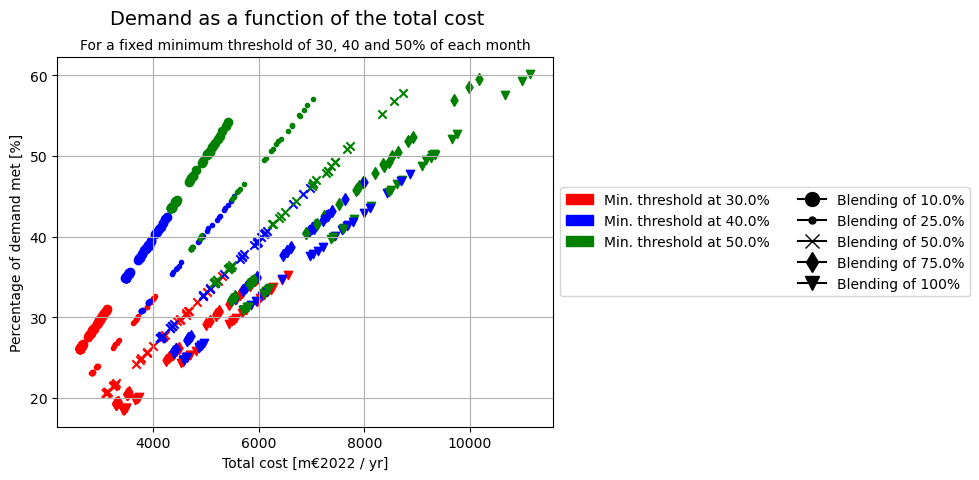

In [43]:
perc_dict = {
    0.3  : 'r',
    0.4  : 'b',
    0.5  : 'g',
}

clusters = [20, 30, 40]
b_acc = [0.1, 0.25, 0.5, 0.75, 1]

marker_dict = {val: markers[i] for i, val in enumerate(b_acc)}

X_data = [[] for _ in range(len(b_acc))]
Y_data = [[] for _ in range(len(b_acc))]

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants['b'].isin(b_acc))]
    
    # ----------------- GET THE VALUES NEEDED -----------------
    
    b = currentCase["b"].values
    perc = currentCase["perc"].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    
    TOTEX = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
        
        X_data[b_acc.index(b[i])].append(TOTEX[i])
        Y_data[b_acc.index(b[i])].append(demand[-1])
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[b_val] for b_val in b]
    
    for i in range(len(TOTEX)):
        plt.scatter(TOTEX[i], demand[i], c=perc_dict[perc[i]], marker=assigned_markers[i])
        
# ----------------- TITLES -----------------

plt.suptitle("Demand as a function of the total cost", y=0.98, fontsize=14)
plt.title('For a fixed minimum threshold of 30, 40 and 50% of each month', fontsize=10)

plt.xlabel("Total cost [m€2022 / yr]")
plt.ylabel("Percentage of demand met [%]")

# ----------------- CUSTOM LEGEND -----------------

handles = []

for i, p in enumerate(perc_dict): # Colors
    handles.append(mpatches.Patch(color=perc_dict[p], label=f"Min. threshold at {100*p}%"))

spacers = ['o'] * 2
for marker in spacers: # Spacers to have it in two columns
    handles.append(mlines.Line2D([], [], color='w', marker=marker, markersize=10, label=""))

for b, marker in marker_dict.items(): # Shapes
    handles.append(mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%"))

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()

plt.savefig("project_data/out/Images/08_02_demand_cost_threshold.png", transparent = True, dpi = 300, bbox_inches='tight')

## Linear regresion of the data

In this part, an analysis of the form of the data is performed to see how linear they are

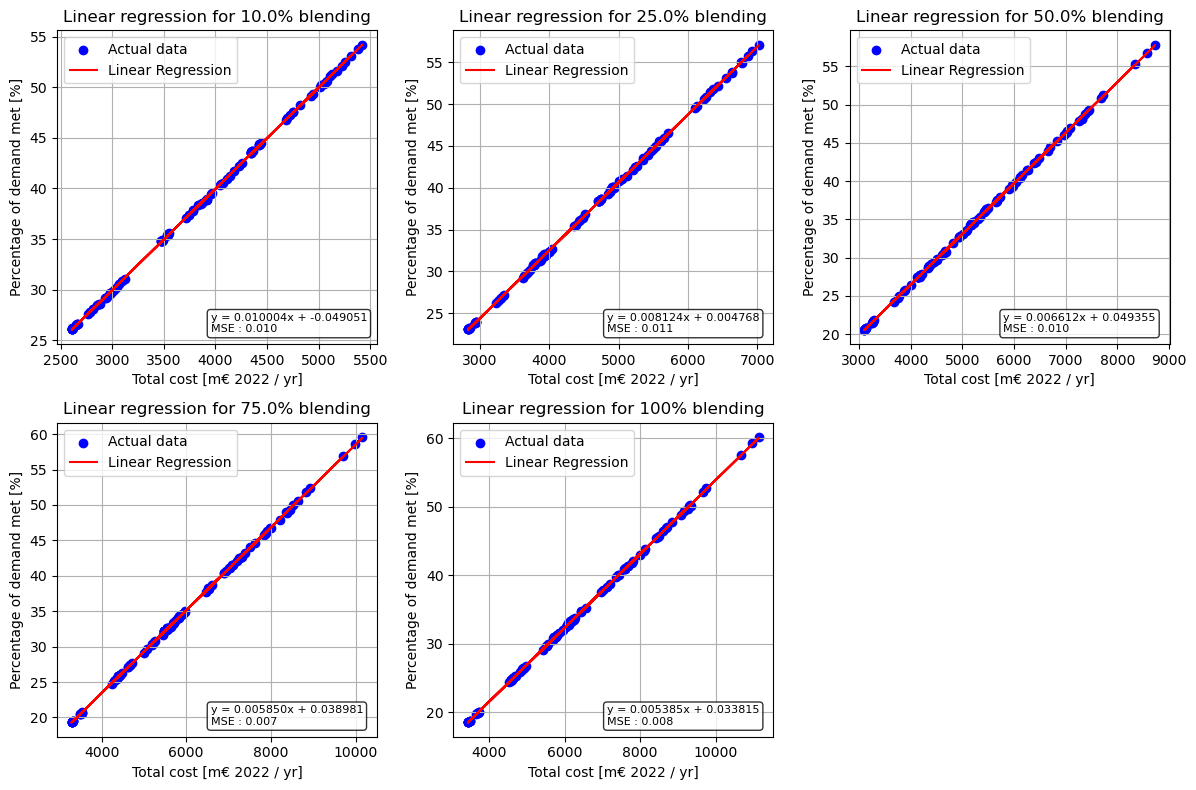

In [44]:
X = np.array(X_data)
Y = np.array(Y_data)

# Creating subplots for each pair of X and Y arrays with a 3x2 grid arrangement
num_plots = X.shape[0]  # Assuming X and Y have the same number of subarrays
num_cols = 3  # Number of columns for subplots
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate number of rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Creating subplots
plt.subplots_adjust(hspace=0.5)  # Increase vertical space between subplots

for i in range(num_plots):
    row = i // num_cols
    col = i % num_cols
    
    model = LinearRegression()
    model.fit(X[i].reshape(-1, 1), Y[i])  # Fitting each pair of arrays
    Y_pred = model.predict(X[i].reshape(-1, 1))
    
    mse = mean_squared_error(Y[i], Y_pred)
    equation = f'y = {model.coef_[0]:.6f}x + {model.intercept_:.6f}\nMSE : {mse:.3f}'  # Linear equation
    
    axs[row, col].scatter(X[i], Y[i], color='blue', label='Actual data')
    axs[row, col].plot(X[i], Y_pred, color='red', label='Linear Regression')
    
    axs[row, col].set_xlabel('Total cost [m€ 2022 / yr]')
    axs[row, col].set_ylabel('Percentage of demand met [%]')
    axs[row, col].set_title(f'Linear regression for {b_acc[i] * 100}% blending')
    
    axs[row, col].text(0.48, 0.1, equation, transform=axs[row, col].transAxes, fontsize=8,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axs[row, col].grid()
    axs[row, col].legend()

# Hiding empty subplots if there are any
for j in range(num_plots, num_cols * num_rows):
    axs[j // num_cols, j % num_cols].axis('off')


plt.tight_layout()

plt.savefig("project_data/out/Images/08_02_linear_regression.png", transparent = True, dpi = 300, bbox_inches='tight')

# The demand as a function of the total cost

In this graph is the same as the previous, however, this time the number of plants is coloured. Also, all the blending percentages considered are shown. Note that sometimes, 20 plants is more expensive to run that 30. This will be explored and explained while considering a specific case.

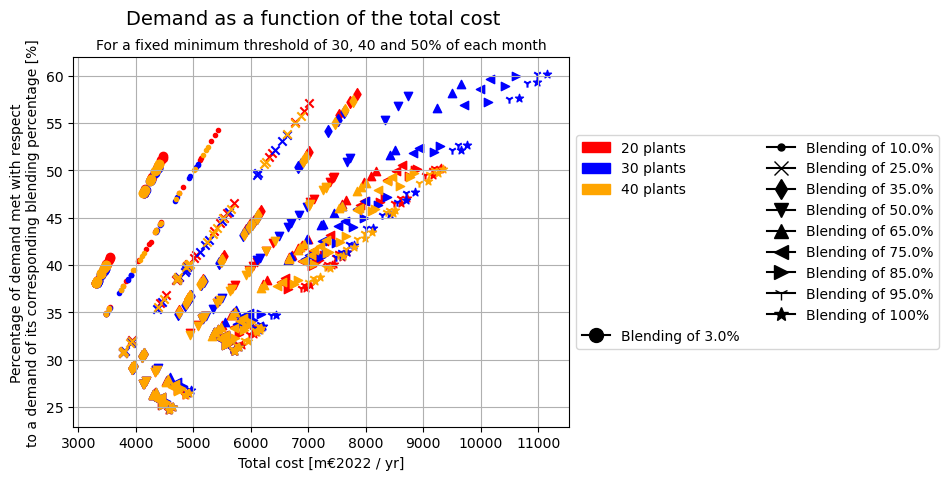

In [45]:
marker_dict = {val: markers[i] for i, val in enumerate(b_values)}
clusters = [20, 30, 40]

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants['perc'] >= 0.4)]
    
    # ----------------- GET THE VALUES -----------------
    
    b = currentCase["b"].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # ----------------- PLOT -----------------
    
    # Assign markers based on b values
    assigned_markers = [marker_dict[val] for val in b]
    
    for i in range(len(TOTEX)):
        plt.scatter(TOTEX[i], demand[i], c=colors[index_n], marker=assigned_markers[i])

# ----------------- TITLES -----------------

plt.suptitle("Demand as a function of the total cost", y=0.98, fontsize=14)
plt.title('For a fixed minimum threshold of 30, 40 and 50% of each month', fontsize=10)

plt.xlabel("Total cost [m€2022 / yr]")
plt.ylabel("Percentage of demand met with respect\nto a demand of its corresponding blending percentage [%]")

# ----------------- CUSTOM LEGEND -----------------

handles = []

for i, n in enumerate(clusters): # Colors
    handles.append(mpatches.Patch(color=colors[i], label=f"{n} plants"))

spacers = ['o'] * 6
for marker in spacers: # Spacers to have it in two columns
    handles.append(mlines.Line2D([], [], color='w', marker=marker, markersize=10, label=""))

for b, marker in marker_dict.items(): # Shape
    handles.append(mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%"))

# ----------------- PLOT AGAIN -----------------
  
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()

# The effect of the reference month on the price

Let us fix `perc` at 40% and see the effect of the reference month on the total price. We can see that when the reference month is set at the low-demand season, the demand met and cost are lower (more to the left) than during high-demand season, (right)

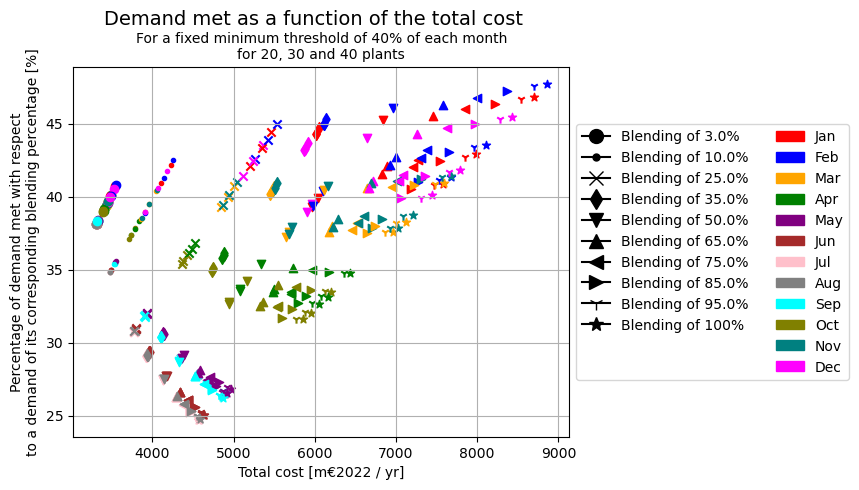

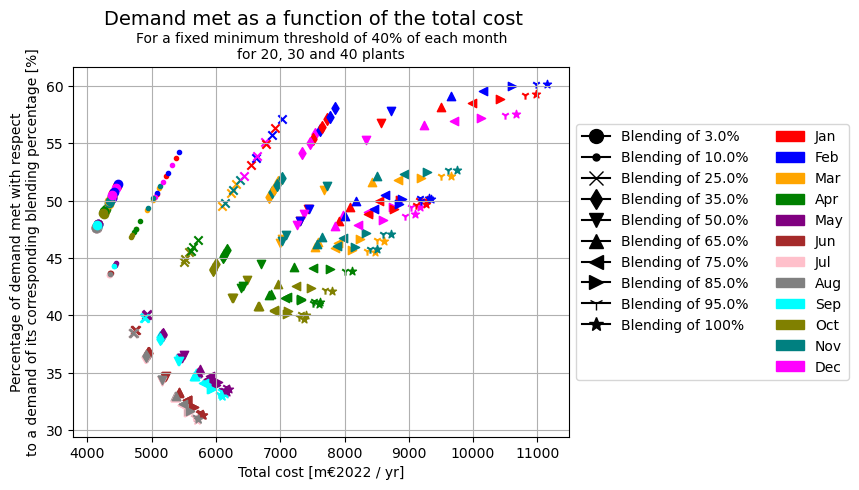

In [64]:
colors_dict = {t: colors[t-1] for t in range(1, 13)}
marker_dict = {val: markers[i] for i, val in enumerate(b_values)}

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants["perc"] == 0.4)]
    
    # ----------------- IMPORT THE VALUES NEEDED -----------------
    
    m = currentCase['m'].values
    b = currentCase['b'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(TOTEX)):
        plt.scatter(TOTEX[i], demand[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    handles.append(mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%"))

spacers = ['o'] * 2
for marker in spacers: # Spacers to have it in two columns
    handles.append(mlines.Line2D([], [], color='w', marker=marker, markersize=10, label=""))

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    handles.append(mpatches.Patch(color=colors[i], label=t))

# ----------------- TITLES -----------------

plt.suptitle("Demand met as a function of the total cost", y=1.0, fontsize=14)
plt.title('For a fixed minimum threshold of 40% of each month\nfor 20, 30 and 40 plants', fontsize=10)

plt.xlabel("Total cost [m€2022 / yr]")
plt.ylabel("Percentage of demand met with respect\nto a demand of its corresponding blending percentage [%]")

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()

plt.savefig("project_data/out/Images/08_03_01_40p_demand_cost_month.png", transparent = True, dpi = 300, bbox_inches='tight')


# ================================== p = 0.5 ==================================

plt.subplots()


colors_dict = {t: colors[t-1] for t in range(1, 13)}
marker_dict = {val: markers[i] for i, val in enumerate(b_values)}

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants["perc"] == 0.5)]
    
    # ----------------- IMPORT THE VALUES NEEDED -----------------
    
    m = currentCase['m'].values
    b = currentCase['b'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(TOTEX)):
        plt.scatter(TOTEX[i], demand[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    handles.append(mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%"))

spacers = ['o'] * 2
for marker in spacers: # Spacers to have it in two columns
    handles.append(mlines.Line2D([], [], color='w', marker=marker, markersize=10, label=""))

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    handles.append(mpatches.Patch(color=colors[i], label=t))

# ----------------- TITLES -----------------

plt.suptitle("Demand met as a function of the total cost", y=1.0, fontsize=14)
plt.title('For a fixed minimum threshold of 40% of each month\nfor 20, 30 and 40 plants', fontsize=10)

plt.xlabel("Total cost [m€2022 / yr]")
plt.ylabel("Percentage of demand met with respect\nto a demand of its corresponding blending percentage [%]")

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()

plt.savefig("project_data/out/Images/08_03_01_50p_demand_cost_month.png", transparent = True, dpi = 300, bbox_inches='tight')

# Cost of hydrogen as a function of the demand met

In this part we will take a look at the cost that is passed onto the consumer. This only takes into consideration the cost of construction, operation and maintenance of the plants. It doesn't account for transport, taxes or profit margins.

We consider two scenarios :
 - An independent Germany that seeks to achieve around 50% of its hydrogen demand locally produced. For this, we chose the minimum threshold (`perc`) to be at 50%. We can then see that the 50% is satisfied taking the months of January, February, March, November or December as reference for building the plants.
 - A minimalist Germany that only wants to achieve 30% of its hydrogen demnand with local production. For this, we first chose the minimum threshold (`perc`) of 30%. We then see that for the same months as before, this 30% is satisfied. However, the gap between the months of March and November and the 30% demand mark is larger in the 50% case, where the months of March and December nearly on the line for some cases.

Furthermore, the high level blending percentages have been taken out, to simulate a Germany that doesn't want to change its large pipe network. So a low blending percentage is chosen to reduce the damage done by hydrogen.

We will later take a look at the potential lost during low-demand season.

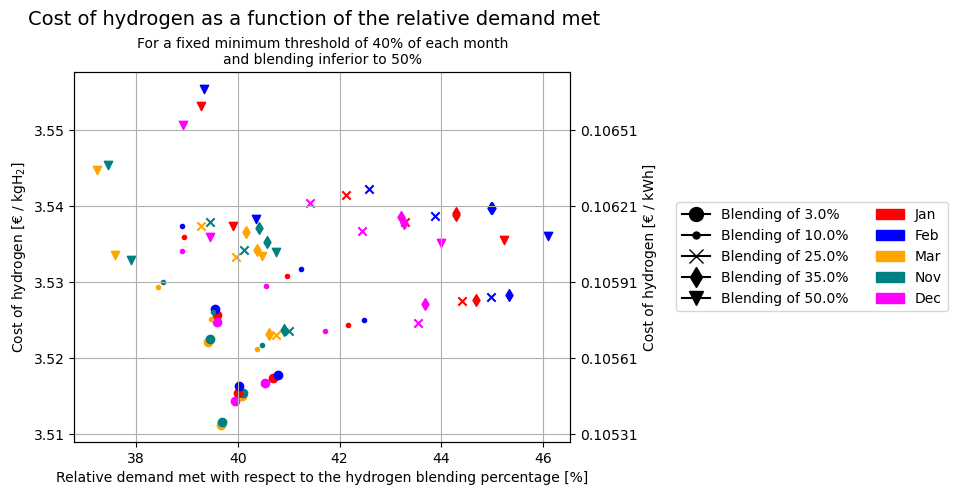

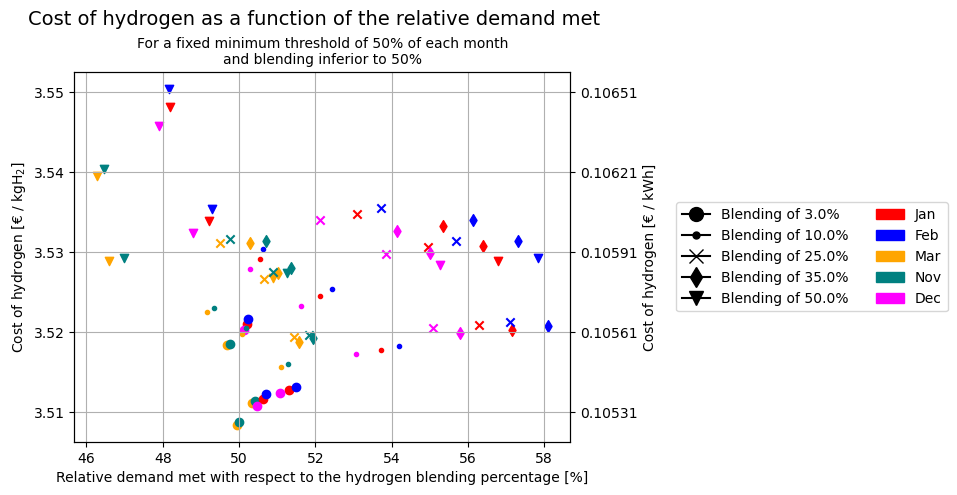

In [65]:
# ============================= COST FOR perc = 0.4 =============================


m_acc = [1, 2, 3, 11, 12]

fig, ax = plt.subplots()
marker_dict = {val: markers[i] for i, val in enumerate(b_values)}
clusters = [20, 30, 40]
for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants["perc"] == 0.4) & 
                            (df_plants['b'] <= 0.5) &
                            (df_plants['m'].isin(m_acc))]
    
    # ----------------- GET THE DATA -----------------
    
    b = currentCase['b'].values
    m = currentCase['m'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # ----------------- COMPUTE THE PRICE -----------------
    yearProd = [sum([sum(t)*daysMonth[index_t] for index_t, t in enumerate(prod)]) for prod in production]
    cost     = [t / p for p, t in zip(yearProd, TOTEX)]
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(demand)):
        plt.scatter(demand[i], cost[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- TITLES -----------------

plt.suptitle("Cost of hydrogen as a function of the relative demand met", y=1.01, fontsize=14)
plt.title('For a fixed minimum threshold of 40% of each month\nand blending inferior to 50%', fontsize=10)

plt.xlabel("Relative demand met with respect to the hydrogen blending percentage [%]")
plt.ylabel("Cost of hydrogen [€ / kgH$_2$]")

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    if (b > 0.5): continue
    marker_handle = mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%")
    handles.append(marker_handle)

spacers = ['o'] * 0
for marker in spacers: # Spacers to have it in two columns
    marker_handle = mlines.Line2D([], [], color='w', marker=marker, markersize=10, label="")
    handles.append(marker_handle)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    if (i+1 not in m_acc): continue
    color_patch = mpatches.Patch(color=colors[i], label=t)
    handles.append(color_patch)

plt.grid()

# ----------------- SECOND AXIS  -----------------

yticks_second = ax.get_yticks() / 33.33

ax2 = ax.twinx()
ax2.set_yticks(yticks_second)

ymin, ymax = ax.get_ylim()
plt.ylim(ymin / 33.33, ymax / 33.33)

ax2.set_ylabel("Cost of hydrogen [€ / kWh]", color='k')

for tick in ax2.get_yticklabels():
    tick.set_color('k')

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=2)


plt.savefig("project_data/out/Images/08_04_02_40p_hydrogen_cost_demand.png", transparent = True, dpi = 300, bbox_inches='tight')




# ============================= COST FOR perc = 0.5 =============================



fig, ax = plt.subplots()

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) & 
                            (df_plants["perc"] == 0.5) & 
                            (df_plants['b'] <= 0.5) &
                            (df_plants['m'].isin(m_acc))]
    
    # ----------------- GET THE DATA -----------------
    
    b = currentCase['b'].values
    m = currentCase['m'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE DEMAND -----------------
    
    demand = []
    for i, prod in enumerate(production):
        _, ref_demand, _, _ , _ = computeHydrogenDemand(b[i], industry=True)
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # ----------------- COMPUTE THE PRICE -----------------
    yearProd = [sum([sum(t)*daysMonth[index_t] for index_t, t in enumerate(prod)]) for prod in production]
    cost     = [t / p for p, t in zip(yearProd, TOTEX)]
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(demand)):
        plt.scatter(demand[i], cost[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- TITLES -----------------

plt.suptitle("Cost of hydrogen as a function of the relative demand met", y=1.01, fontsize=14)
plt.title('For a fixed minimum threshold of 50% of each month\nand blending inferior to 50%', fontsize=10)

plt.xlabel("Relative demand met with respect to the hydrogen blending percentage [%]")
plt.ylabel("Cost of hydrogen [€ / kgH$_2$]")

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    if (b > 0.5): continue
    marker_handle = mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%")
    handles.append(marker_handle)

spacers = ['o'] * 0
for marker in spacers: # Spacers to have it in two columns
    marker_handle = mlines.Line2D([], [], color='w', marker=marker, markersize=10, label="")
    handles.append(marker_handle)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    if (i+1 not in m_acc): continue
    color_patch = mpatches.Patch(color=colors[i], label=t)
    handles.append(color_patch)

plt.grid()

# ----------------- SECOND AXIS  -----------------

yticks_second = ax.get_yticks() / 33.33

ax2 = ax.twinx()

ax2.set_yticks(yticks_second)

ymin, ymax = ax.get_ylim()
plt.ylim(ymin / 33.33, ymax / 33.33)

ax2.set_ylabel("Cost of hydrogen [€ / kWh]", color='k')

for tick in ax2.get_yticklabels():
    tick.set_color('k')


# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=2)

plt.savefig("project_data/out/Images/08_04_02_50p_hydrogen_cost_demand.png", transparent = True, dpi = 300, bbox_inches='tight')

# Carbon reduction per euro spent

In this part, as before, we will consider the previous scenarios, $perc \in [0.3, 0.5] $ and $b \leq 0.5$. We will take a look at the evolution of the carbon removed per dollar spent, as well as the total emissions saved. This time, however, we only keep the months of January, February, March, November and December.

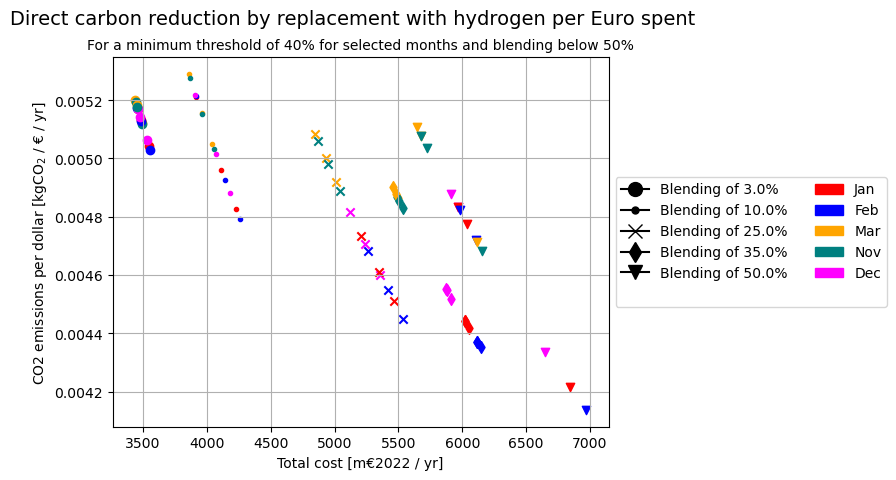

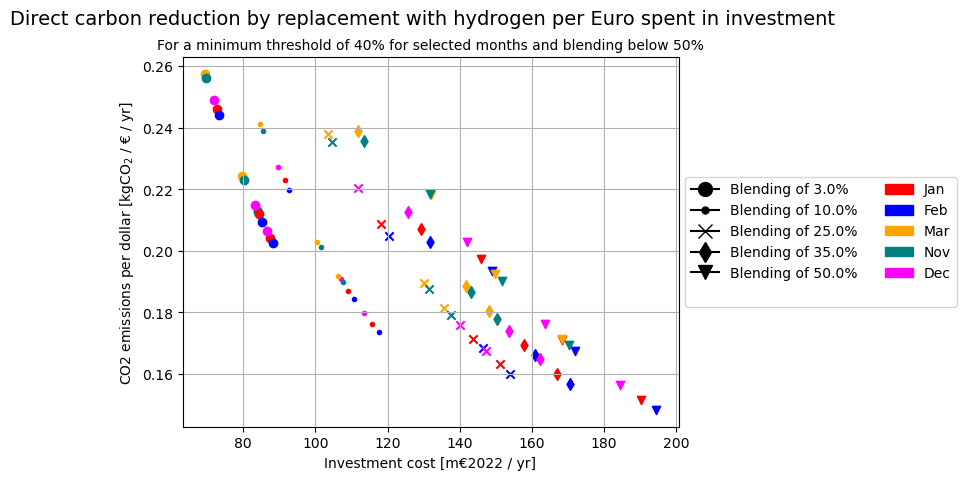

In [62]:
# ============================= CARBON REDUCTION FOR perc = 0.5 =============================

marker_dict = {val: markers[i] for i, val in enumerate(b_values)}
valid_months = [1, 2, 3, 11, 12] # Jan, Feb, Mar, Nov, Dec

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) &
                            (df_plants['perc'] == 0.4) &
                            (df_plants['b'] <= 0.5) &
                            (df_plants['m'].isin(valid_months))]
    
    # ----------------- GET THE DATA -----------------
    
    b = currentCase['b'].values
    m = currentCase['m'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    TOTEX    = USD2EUR([(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))])
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE CARBON REDUCTION -----------------
    
    carbonReduction = []
    for i, prod in enumerate(production):
        _, _, _, emissions, _ = computeHydrogenDemand(b[i], industry=True)
        carbonReduction.append(emissions / (1e6 * TOTEX[i]))
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(carbonReduction)):
        plt.scatter(TOTEX[i], carbonReduction[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- TITLES -----------------

plt.suptitle("Direct carbon reduction by replacement with hydrogen per Euro spent", y=0.98, fontsize=14)
plt.title('For a minimum threshold of 40% for selected months and blending below 50%', fontsize=10)

plt.xlabel("Total cost [m€2022 / yr]")
plt.ylabel("CO2 emissions per dollar [kgCO$_2$ / € / yr]")

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    if (b > 0.5): continue
    marker_handle = mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%")
    handles.append(marker_handle)

spacers = ['o'] * 1
for marker in spacers: # Spacers to have it in two columns
    marker_handle = mlines.Line2D([], [], color='w', marker=marker, markersize=10, label="")
    handles.append(marker_handle)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    if (i+1 not in valid_months): continue
    color_patch = mpatches.Patch(color=colors[i], label=t)
    handles.append(color_patch)

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()


plt.savefig("project_data/out/Images/08_04_01_40p_co2_reduction_totex.png", transparent = True, dpi = 300, bbox_inches='tight')

# ============================= CARBON REDUCTION FOR CAPEX =============================
plt.subplots()


marker_dict = {val: markers[i] for i, val in enumerate(b_values)}
valid_months = [1, 2, 3, 11, 12] # Jan, Feb, Mar, Nov, Dec

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants['n'] == n) &
                            (df_plants['perc'] == 0.4) &
                            (df_plants['b'] <= 0.5) &
                            (df_plants['m'].isin(valid_months))]
    
    # ----------------- GET THE DATA -----------------
    
    b = currentCase['b'].values
    m = currentCase['m'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totCAPEX = [sum(c) / 1e6 for c in totCAPEX]
    
    # ----------------- COMPRESS THE MONTHLY PRODUCTION INTO A SINGLE ARRAY -----------------
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    # ----------------- COMPUTE THE CARBON REDUCTION -----------------
    
    carbonReduction = []
    for i, prod in enumerate(production):
        _, _, _, emissions, _ = computeHydrogenDemand(b[i], industry=True)
        carbonReduction.append(emissions / (1e6 * totCAPEX[i]))
    
    # ----------------- PLOT -----------------
    
    assigned_markers = [marker_dict[val] for val in b]
    assigned_colors  = [colors_dict[val] for val in m]
    
    for i in range(len(carbonReduction)):
        plt.scatter(totCAPEX[i], carbonReduction[i], c=assigned_colors[i], marker=assigned_markers[i])

# ----------------- TITLES -----------------

plt.suptitle("Direct carbon reduction by replacement with hydrogen per Euro spent in investment", y=0.98, fontsize=14)
plt.title('For a minimum threshold of 40% for selected months and blending below 50%', fontsize=10)

plt.xlabel("Investment cost [m€2022 / yr]")
plt.ylabel("CO2 emissions per dollar [kgCO$_2$ / € / yr]")

# ----------------- CUSTOM LEGEND -----------------
handles = []

for b, marker in marker_dict.items(): # Shapes
    if (b > 0.5): continue
    marker_handle = mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%")
    handles.append(marker_handle)

spacers = ['o'] * 1
for marker in spacers: # Spacers to have it in two columns
    marker_handle = mlines.Line2D([], [], color='w', marker=marker, markersize=10, label="")
    handles.append(marker_handle)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, t in enumerate(months): # Colors
    if (i+1 not in valid_months): continue
    color_patch = mpatches.Patch(color=colors[i], label=t)
    handles.append(color_patch)

# ----------------- PLOT AGAIN -----------------

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()



plt.savefig("project_data/out/Images/08_04_01_40p_co2_reduction_capex.png", transparent = True, dpi = 300, bbox_inches='tight')

# Usage analysis

In this part we will analyse at what point the plants are used. For this analysis, a blending and minimum threshold of 50\% will be considered. As well as the cases with 20, 30 and 40 plants

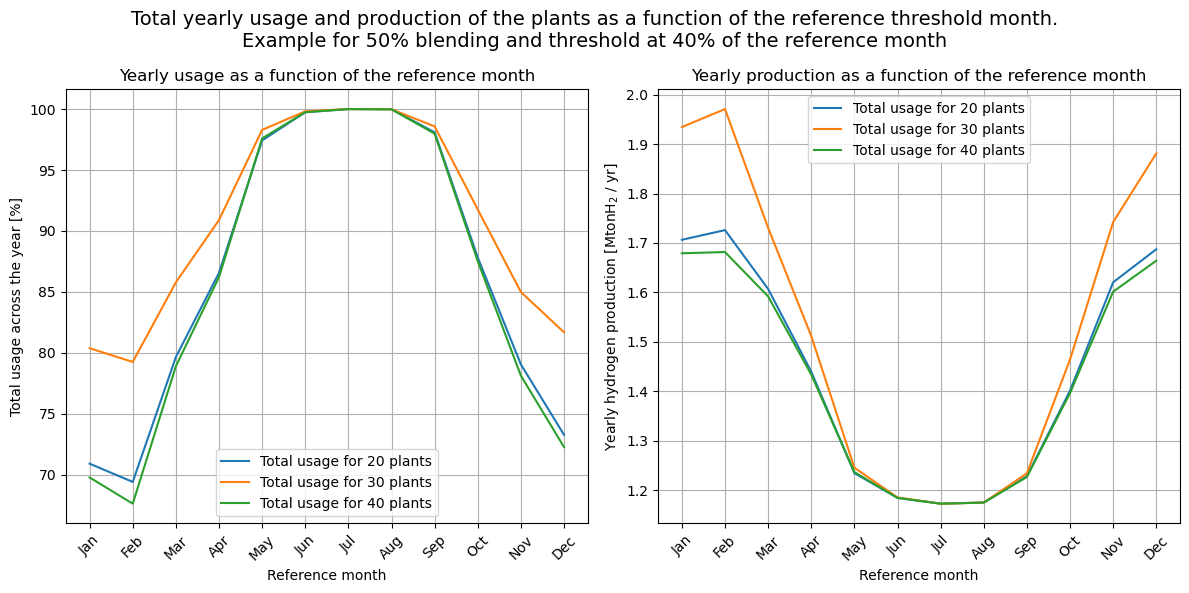

In [49]:
import matplotlib.pyplot as plt

# ======================= Total Usage =====================

clusters = [20, 30, 40]
plt.figure(figsize=(12, 6))

for index_n, n in enumerate(clusters):
    
    tot_usage = []
    for m in range(1, 13):
        currentCase = df_plants[(df_plants["perc"] == 0.4) &
                            (df_plants['m'] == m) &
                            (df_plants['b'] == 0.5)]

        currentCase = currentCase[currentCase['n'] == n]

        usage = []
        capacity = currentCase["capacity"].values[0]
        capacity = [c * sum(daysMonth) for c in capacity]
        
        production = []
        for i in range(n):
            production.append([currentCase[f"production {t}"].values[0][i] * daysMonth[t - 1] for t in range(1, 13)])
        
        tot_usage.append(100 * sum([sum(p) for p in production]) / sum(capacity))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(12), tot_usage, label=f"Total usage for {n} plants")

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.subplot(1, 2, 1)
plt.xticks(range(12), months, rotation=45)

plt.title("Yearly usage as a function of the reference month")

plt.ylabel("Total usage across the year [%]")
plt.xlabel("Reference month")

plt.legend(loc="lower center")
plt.grid()

# ======================= Production =====================

clusters = [20, 30, 40]
plt.subplot(1, 2, 2)

for index_n, n in enumerate(clusters):
    
    tot_usage = []
    for m in range(1, 13):
        currentCase = df_plants[(df_plants["perc"] == 0.4) &
                            (df_plants['m'] == m) &
                            (df_plants['b'] == 0.5)]

        currentCase = currentCase[currentCase['n'] == n]

        usage = []
        capacity = currentCase["capacity"].values[0]
        capacity = [c * sum(daysMonth) for c in capacity]
        
        production = []
        for i in range(n):
            production.append([currentCase[f"production {t}"].values[0][i] * daysMonth[t - 1] for t in range(1, 13)])
        
        tot_usage.append(sum([sum(p) / 1e9 for p in production]))
    
    plt.plot(range(12), tot_usage, label=f"Total usage for {n} plants")

plt.xticks(range(12), months, rotation=45)

plt.suptitle("Total yearly usage and production of the plants as a function of the reference threshold month.\nExample for 50% blending and threshold at 40% of the reference month", y=0.98, fontsize=14)
plt.title("Yearly production as a function of the reference month")

plt.ylabel("Yearly hydrogen production [MtonH$_2$ / yr]")
plt.xlabel("Reference month")

plt.legend(loc="upper center")
plt.grid()

plt.tight_layout()

plt.savefig("project_data/out/Images/08_03_02_yearly_usage.png", transparent = True, dpi = 300, bbox_inches='tight')

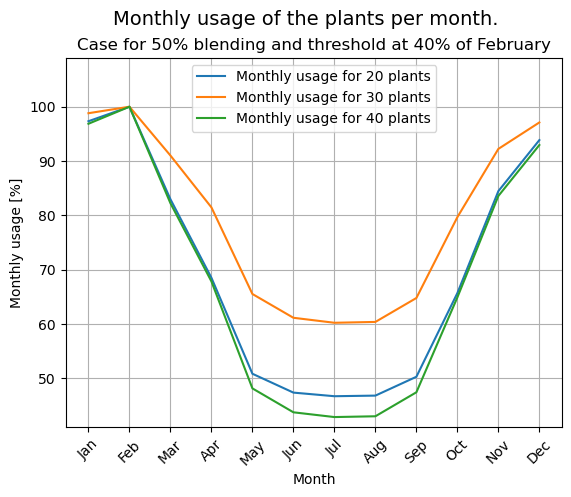

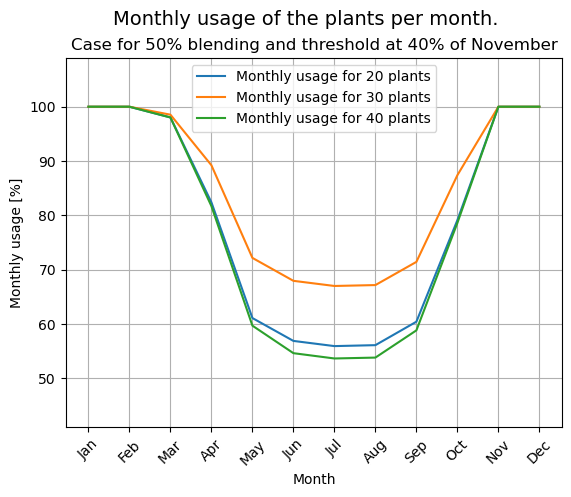

In [50]:
m = 2

for n in clusters:
    currentCase = df_plants[(df_plants["perc"] == 0.4) &
                                (df_plants['m'] == m) &
                                (df_plants['b'] == 0.5)]

    currentCase = currentCase[currentCase['n'] == n]

    capacity = currentCase['capacity'].values[0]

    production = []
    for t in range(1, 13):
        production.append([currentCase[f"production {t}"].values[0][i] for i in range(n)])

    production = [sum(p) for p in production]
    plt.plot(range(12), [100 * p / sum(capacity) for p in production], label = f"Monthly usage for {n} plants")

plt.suptitle("Monthly usage of the plants per month.", y = 0.98, fontsize=14)
plt.title(f"Case for 50% blending and threshold at 40% of February")

plt.xlabel("Month")
plt.ylabel("Monthly usage [%]")

plt.ylim([41, 109])
plt.xticks(range(12), months, rotation=45)

plt.legend()
plt.grid()

plt.savefig("project_data/out/Images/08_03_02_monthly_usage.png", transparent = True, dpi = 300, bbox_inches='tight')

# ======================== JULY =========================
plt.subplots()
m = 11

for n in clusters:
    currentCase = df_plants[(df_plants["perc"] == 0.4) &
                                (df_plants['m'] == m) &
                                (df_plants['b'] == 0.5)]

    currentCase = currentCase[currentCase['n'] == n]

    capacity = currentCase['capacity'].values[0]

    production = []
    for t in range(1, 13):
        production.append([currentCase[f"production {t}"].values[0][i] for i in range(n)])

    production = [sum(p) for p in production]
    plt.plot(range(12), [100 * p / sum(capacity) for p in production], label = f"Monthly usage for {n} plants")

plt.suptitle("Monthly usage of the plants per month.", y = 0.98, fontsize=14)
plt.title(f"Case for 50% blending and threshold at 40% of November")

plt.xlabel("Month")
plt.ylabel("Monthly usage [%]")

plt.ylim([41, 109])
plt.xticks(range(12), months, rotation=45)

plt.legend()
plt.grid()

plt.savefig("project_data/out/Images/08_03_02_11_monthly_usage.png", transparent = True, dpi = 300, bbox_inches='tight')

# TOTEX analysis

The cost analysis is performed as a function of the number of plants $n$ and with the following configuration :

| **perc** |     **m**    | **b** |
|:--------:|:------------:|:-----:|
|    40%   | 12 (December)|   3%  |


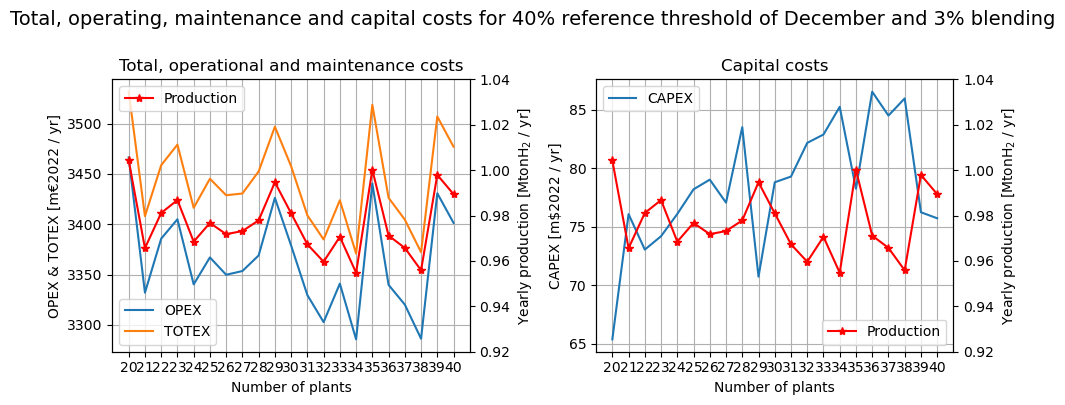

In [51]:
# ============================= POPULATION FOR perc = 0.4 =============================

currentCase = df_plants[(df_plants["perc"] == 0.4) &
                        (df_plants['m'] == 12) &
                        (df_plants['b'] == 0.03)]

# ----------------- GET THE DATA -----------------

n = currentCase['n'].values

capex = USD2EUR([sum(c) / 1e6 for c in currentCase['CAPEX'].values])
opex  = USD2EUR([sum(o) / 1e6 for o in currentCase['OPEX'].values])

totex = [c+o for c, o in zip(capex, opex)]

# ----------------- COMPUTE PRODUCTION -----------------

production = [0] * len(capex) 
for i in range(len(capex)):
    for t in range(1, 13):
        production[i] += sum(list(currentCase[f'production {t}'].values)[i]) * daysMonth[t-1]

# ----------------- PLOT -----------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ----------------- LEFT PLOT -----------------

ax1.plot(n, opex, label="OPEX")
ax1.plot(n, totex, label="TOTEX")

plt.suptitle("Total, operating, maintenance and capital costs for 40% reference threshold of December and 3% blending", y=1, fontsize=14)

ax1.set_title('Total, operational and maintenance costs')
ax1.set_xlabel('Number of plants')
ax1.set_ylabel('OPEX & TOTEX [m€2022 / yr]')

ax1.set_xticks(np.arange(20, 41))

ax1.legend()
ax1.grid()

# Adding a second y-axis to the left plot for 'production'
ax1twin = ax1.twinx()

ax1twin.plot(n, [p / 1e9 for p in production], 'r*-', label='Production')

ax1twin.set_ylabel('Yearly production [MtonH$_2$ / yr]')

ax1twin.set_ylim([0.92, 1.04])

ax1twin.legend(loc='upper left')  # Legend for production data

# ----------------- RIGHT PLOT -----------------

ax2.plot(n, capex, label="CAPEX")

ax2.set_title('Capital costs')
ax2.set_xlabel('Number of plants')
ax2.set_ylabel('CAPEX [m$2022 / yr]')

ax2.grid()

# Adding a second y-axis to the right plot for 'production'
ax2twin = ax2.twinx()

ax2twin.plot(n, [p / 1e9 for p in production], 'r*-', label='Production')
ax2twin.set_ylim([0.92, 1.04])
ax2twin.set_ylabel('Yearly production [MtonH$_2$ / yr]')

ax2twin.legend(loc='lower right')  # Legend for production data

ax2.legend()
plt.tight_layout()
plt.xticks(range(20, 41))

plt.savefig("project_data/out/Images/08_05_01_OPEX_CAPEX_production.png", transparent = True, dpi = 300, bbox_inches='tight')

## Analysis of the CAPEX

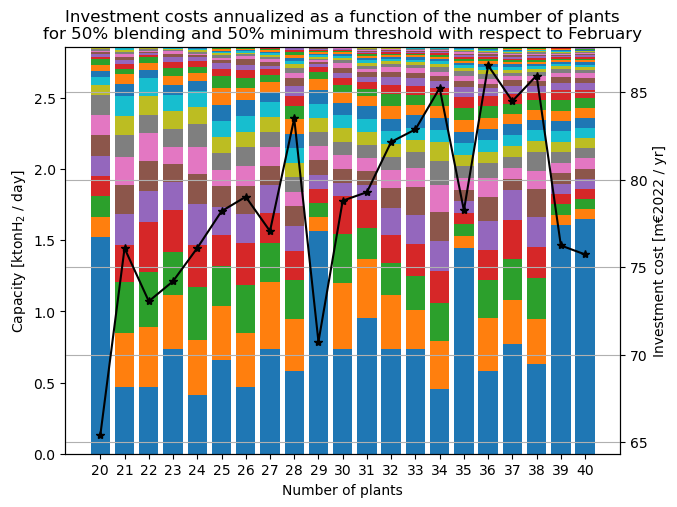

In [52]:
currentCase = df_plants[(df_plants["perc"] == 0.4) &
                        (df_plants['m'] == 12) &
                        (df_plants['b'] == 0.03)]

plantsSpe = [list(A) for A in currentCase['capacity'].values]
CAPEX = [list(USD2EUR(A)) for A in currentCase['CAPEX'].values]
OPEX = [list(USD2EUR(A)) for A in currentCase['OPEX'].values]

data = [sorted([r/1e6 for r in row], reverse=True) for row in plantsSpe] # Sort so the largest plants are at the bottom

num_bars = len(data)

# Create stacked bar plot
fig, ax = plt.subplots()

max_elements = max(len(row) for row in data)
bottom = np.zeros(num_bars)

for i in range(max_elements):
    values = [row[i] if i < len(row) else 0 for row in data]
    ax.bar(np.arange(num_bars), values, bottom=bottom)
    bottom += np.array(values)

plt.xticks(np.arange(num_bars), np.arange(len(plantsSpe[0]), len(plantsSpe[-1]) + 1))

plt.xlabel('Number of plants')
plt.ylabel('Capacity [ktonH$_2$ / day]')
#plt.title('Stacked plants capacity as a function of the number of plants\n')

plt.tight_layout()
#plt.show()

# Second plot

#plt.subplots()
ax2 = plt.twinx()

#ax2.plot(n, [p / 1e9 for p in production], 'r*-', label='Production')

ax2.set_ylabel('Yearly production [MtonH$_2$ / yr]')

ax2.plot(np.arange(num_bars), [sum(a) / 1e6 for a in CAPEX], 'k-*')

#plt.xticks(range(20, 41))

plt.suptitle("")

plt.title("Investment costs annualized as a function of the number of plants\nfor 50% blending and 50% minimum threshold with respect to February")
plt.ylabel("Investment cost [m€2022 / yr]")
plt.xlabel("Number of plants")

plt.grid()

plt.savefig("project_data/out/Images/08_05_01_stacked_capacity_CAPEX.png", transparent = True, dpi = 300, bbox_inches='tight')

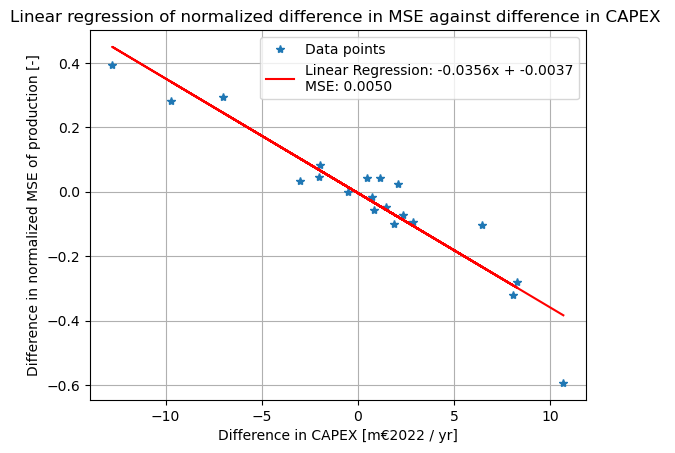

In [58]:
MSE_cap = [(sum([(c - (sum(cap) / len(cap)))**2 for c in cap]))**(1/2) / len(cap) for cap in plantsSpe]
MSE_cap = [m / max(MSE_cap) for m in MSE_cap]

diff_MSE = [MSE_cap[i] - MSE_cap[i-1] for i in range(1, len(MSE_cap))]
diff_CAP = [(sum(CAPEX[i]) - sum(CAPEX[i-1])) / 1e6 for i in range(1, len(CAPEX))]

coefficients = np.polyfit(diff_CAP, diff_MSE, 1)
poly = np.poly1d(coefficients)

# Compute the predicted values using the linear model
predicted_diff_MSE = poly(diff_CAP)

# Compute the Mean Squared Error (MSE)
mse = np.mean((diff_MSE - predicted_diff_MSE)**2)

# Plot the data and the regression line with the MSE in the label
plt.plot(diff_CAP, diff_MSE, '*', label='Data points')
plt.plot(diff_CAP, predicted_diff_MSE, '-', label=f'Linear Regression: {coefficients[0]:.4f}x + {coefficients[1]:.4f}\nMSE: {mse:.4f}', color='red')

plt.xlabel("Difference in CAPEX [m€2022 / yr]")
plt.ylabel("Difference in normalized MSE of production [-]")

plt.title("Linear regression of normalized difference in MSE against difference in CAPEX ")

plt.legend()
plt.grid()

plt.savefig("project_data/out/Images/08_05_01_MSE_CAPEX.png", transparent = True, dpi = 300, bbox_inches='tight')

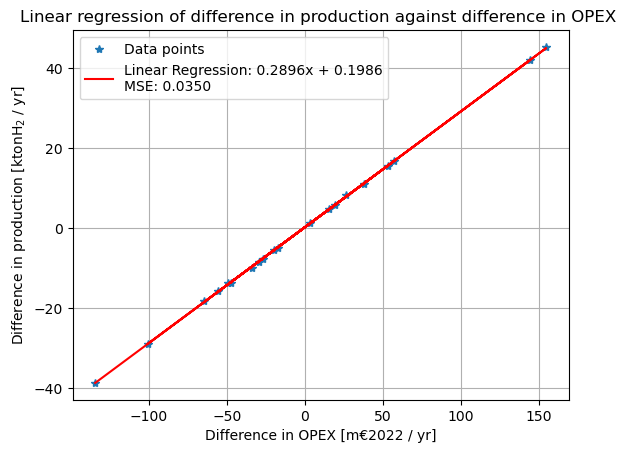

In [59]:
production = [0] * len(capex) 
for i in range(len(capex)):
    for t in range(1, 13):
        production[i] += sum(list(currentCase[f'production {t}'].values)[i]) * daysMonth[t-1]
        
diff_OPE = [(sum(OPEX[i]) - sum(OPEX[i-1])) / 1e6 for i in range(1, len(OPEX))]
diff_PRD = [(production[i] - production[i-1]) / 1e6 for i in range(1, len(production))]

coefficients = np.polyfit(diff_OPE, diff_PRD, 1)
poly = np.poly1d(coefficients)

# Compute the predicted values using the linear model
predicted_diff_PRD = poly(diff_OPE)

# Compute the Mean Squared Error (MSE)
mse = np.mean((diff_PRD - predicted_diff_PRD)**2)

# Plot the data and the regression line with the MSE in the label
plt.plot(diff_OPE, diff_PRD, '*', label='Data points')
plt.plot(diff_OPE, predicted_diff_PRD, '-', label=f'Linear Regression: {coefficients[0]:.4f}x + {coefficients[1]:.4f}\nMSE: {mse:.4f}', color='red')

plt.xlabel("Difference in OPEX [m€2022 / yr]")
plt.ylabel("Difference in production [ktonH$_2$ / yr]")

plt.title("Linear regression of difference in production against difference in OPEX ")

plt.legend()
plt.grid()

plt.savefig("project_data/out/Images/08_05_01_MSE_OPEX.png", transparent = True, dpi = 300, bbox_inches='tight')

# OPEX as a function of month analysis

This analysis is performed for a $n \in [20, 25, 30, 35, 40]$ plants and the same configuration as before :


| **perc** |     **m**    | **b** |
|:--------:|:------------:|:-----:|
|    50%   | 2 (February) |  50%  |

We can see that during the summer months, the only costs are the maintenance and operations costs of the plants, since solar power is used to generate hydrogen.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

clusters = [20, 25, 30, 35, 40]
for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants["perc"] == 0.5) &
                            (df_plants['m'] == 1) &
                            (df_plants['b'] == 0.25)]
    
    currentCase = currentCase[currentCase['n'] == n]
    
    # ----------------- GET THE DATA -----------------
    
    location = currentCase['locations'].values[0]
    
    OPEX  = USD2EUR(currentCase['OPEX'].values[0])
    CAPEX = USD2EUR(currentCase['CAPEX'].values[0])
    
    area = currentCase['Area'].values[0]
    
    servs = currentCase['servings'].values[0]
    
    # ----------------- COMPRESS THE PRODUCTION -----------------
    
    production = []
    for i in range(n):
        production.append([currentCase[f"production {t}"].values[0][i] for t in range(1, 13)])
    
    prod_t = [0] * 12
    for i in range(n):
        for t in range(12):
            prod_t[t] += production[i][t] * daysMonth[t] / 1e6
    
    # ----------------- FIND THE TOTAL OPEX -----------------
    
    OPEX_t_n = [0] * 12
    
    for i in range(n):
        OPEX_t, _, _, _ = computeMonthlyOPEX(location[i], area[i], production[i], CAPEX[i])
        for t in range(12):
            OPEX_t_n[t] += OPEX_t[t] / 1e6
    
    # ----------------- PLOT -----------------
    
    ax1.plot(OPEX_t_n, label=f"{n} plants")
    ax2.plot(prod_t, label=f"{n} plants")
    

plt.suptitle("Relation between production and OPEX", y=1.03, fontsize=14)
    
# ----------------- TITLES LEFT -----------------

ax1.set_title("Operation and maintenance costs\nas a function of the month")

ax1.set_xlabel("Month")
ax1.set_ylabel("Costs [m€2022 / yr]")

ax1.set_xticks(range(12), months, rotation=45)

ax1.legend()
ax1.grid()

# ----------------- TITLES RIGHT -----------------

ax2.set_title("Monthly production")

ax2.set_xlabel("Month")
ax2.set_ylabel("Total production [ktonH$_2$ / month]")

ax2.set_xticks(range(12), months, rotation=45)

ax2.legend()
ax2.grid()

# Hydrogen origin as a function of the month

In here we just colour the bar plots to show where hydrogen comes from

In [ ]:
clusters = [20, 30, 40]
for index_n, n in enumerate(clusters):
    if (index_n > 0): plt.subplots()
    
    currentCase = df_plants[(df_plants["perc"] == 0.4) &
                            (df_plants['m'] == 12) &
                            (df_plants['b'] == 0.03)]
    
    currentCase = currentCase[currentCase['n'] == n]
    
    # ----------------- GET THE DATA -----------------
    
    location = currentCase['locations'].values[0]
    
    OPEX  = USD2EUR(currentCase['OPEX'].values[0])
    CAPEX = USD2EUR(currentCase['CAPEX'].values[0])
    
    area = currentCase['Area'].values[0]
    
    capacity = currentCase["capacity"].values[0]
    
    # ----------------- COMPRESS THE PRODUCTION -----------------
    
    production = []
    for i in range(n):
        production.append([currentCase[f"production {t}"].values[0][i] for t in range(1, 13)])
    
    # ----------------- FIND THE TOTAL OPEX -----------------
    
    H2_solar_n = [0] * 12 # Hydrogen produced from solar energy                       kgH2/month
    H2_elec_n  = [0] * 12 # Hydrogen produced from grid electricity                   kgH2/month
    H2_extra_n = [0] * 12 # Hydrogen that could have been produced from solar energy  kgH2/month
    
    H2_imported = [0] * 12 # Hydrogen that needs to be imported
    
    etaH2 = 0.7
    HHV_H2 = 33.33 # kWh/kgH2
    
    for i in range(n):
        OPEX_t, P_solar, P_elec, P_extra = computeMonthlyOPEX(location[i], area[i], production[i], CAPEX[i], c_elec = [0.08]* 12)
        
        for t in range(12):
            H2_solar_n[t] += P_solar[t] * etaH2 / HHV_H2 # kgH2/month
            H2_elec_n[t]  += P_elec[t]  * etaH2 / HHV_H2 # kgH2/month
            H2_extra_n[t] += P_extra[t] * etaH2 / HHV_H2 # kgH2/month
    
    prod_t = [sum([production[i][t] for i in range(n)]) * daysMonth[t] for t in range(12)]
    
    # Resize the data
    for t in range(12):
        H2_elec_n[t] /= 1e6
        H2_solar_n[t] /= 1e6
        prod_t[t] /= 1e6
    
    # Plotting the stacked bar plot
    plt.bar([t for t in range(12)], H2_elec_n, label='H$_2$ from grid electricity')
    plt.bar([t for t in range(12)], H2_solar_n, bottom=H2_elec_n, label='H$_2$ from solar electricity')
    
    plt.plot([t for t in range(12)], prod_t, 'r:_', label='Total hydrogen production')
    
    # Adding labels and title
    plt.xlabel('Month')
    plt.ylabel('Hydrogen produced [ktonH$_2$ / month]')
    
    plt.suptitle(f"Origin of hydrogen produced per month for a\nminimum threshold of 40% of December and blending of 3%", y=1.03, fontsize=14)
    plt.title(f'Case for {n} plants')
    plt.xticks(range(12), months, rotation=45)
    
    plt.grid()
    plt.legend()
    
    plt.savefig("project_data/out/Images/08_05_02_hydrogen_origin.png", transparent = True, dpi = 300, bbox_inches='tight')

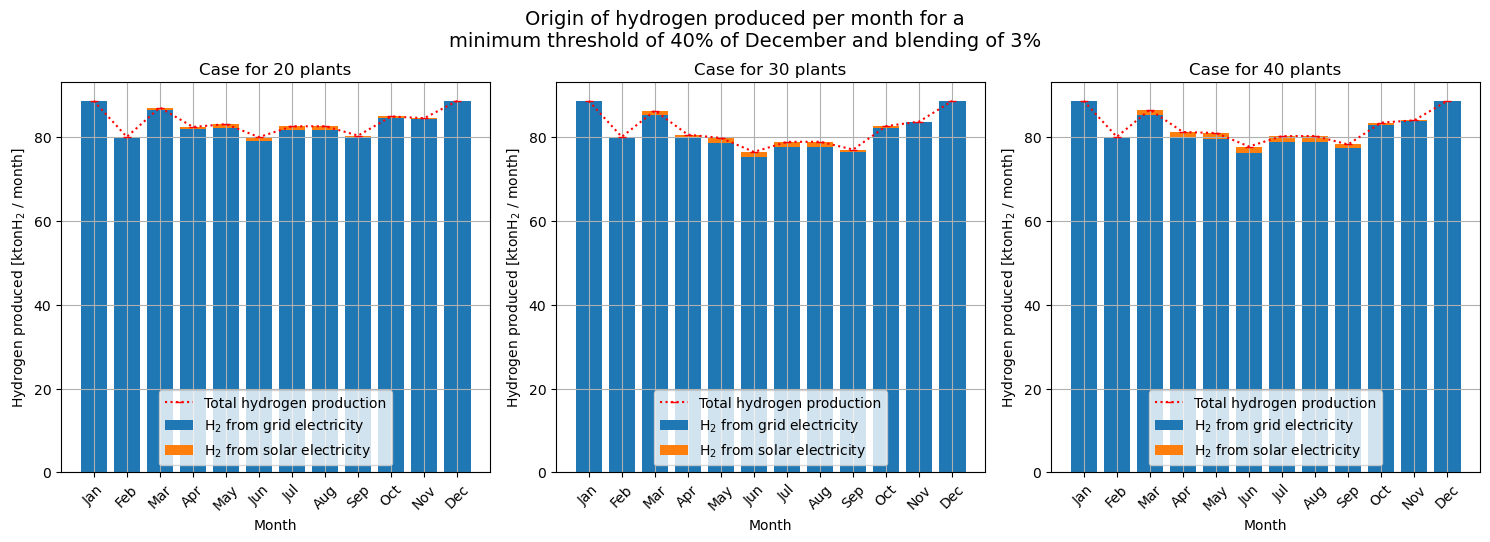

In [80]:
clusters = [20, 30, 40]
fig, axs = plt.subplots(1, len(clusters), figsize=(15, 5))  # 1 row, len(clusters) columns

for index_n, n in enumerate(clusters):
    currentCase = df_plants[(df_plants["perc"] == 0.4) &
                            (df_plants['m'] == 12) &
                            (df_plants['b'] == 0.03)]
    
    currentCase = currentCase[currentCase['n'] == n]
    
    # ----------------- GET THE DATA -----------------
    
    location = currentCase['locations'].values[0]
    
    OPEX  = USD2EUR(currentCase['OPEX'].values[0])
    CAPEX = USD2EUR(currentCase['CAPEX'].values[0])
    
    area = currentCase['Area'].values[0]
    
    capacity = currentCase["capacity"].values[0]
    
    # ----------------- COMPRESS THE PRODUCTION -----------------
    
    production = []
    for i in range(n):
        production.append([currentCase[f"production {t}"].values[0][i] for t in range(1, 13)])
    
    # ----------------- FIND THE TOTAL OPEX -----------------
    
    H2_solar_n = [0] * 12 # Hydrogen produced from solar energy                       kgH2/month
    H2_elec_n  = [0] * 12 # Hydrogen produced from grid electricity                   kgH2/month
    H2_extra_n = [0] * 12 # Hydrogen that could have been produced from solar energy  kgH2/month
    
    H2_imported = [0] * 12 # Hydrogen that needs to be imported
    
    etaH2 = 0.7
    HHV_H2 = 33.33 # kWh/kgH2
    
    for i in range(n):
        OPEX_t, P_solar, P_elec, P_extra = computeMonthlyOPEX(location[i], area[i], production[i], CAPEX[i], c_elec = [0.08]* 12)
        
        for t in range(12):
            H2_solar_n[t] += P_solar[t] * etaH2 / HHV_H2 # kgH2/month
            H2_elec_n[t]  += P_elec[t]  * etaH2 / HHV_H2 # kgH2/month
            H2_extra_n[t] += P_extra[t] * etaH2 / HHV_H2 # kgH2/month
    
    prod_t = [sum([production[i][t] for i in range(n)]) * daysMonth[t] for t in range(12)]
    
    # Resize the data
    for t in range(12):
        H2_elec_n[t] /= 1e6
        H2_solar_n[t] /= 1e6
        prod_t[t] /= 1e6
    
    # Plotting the stacked bar plot on the current subplot
    axs[index_n].bar([t for t in range(12)], H2_elec_n, label='H$_2$ from grid electricity')
    axs[index_n].bar([t for t in range(12)], H2_solar_n, bottom=H2_elec_n, label='H$_2$ from solar electricity')
    
    axs[index_n].plot([t for t in range(12)], prod_t, 'r:_', label='Total hydrogen production')
    
    # Adding labels and title to the current subplot
    axs[index_n].set_xlabel('Month')
    axs[index_n].set_ylabel('Hydrogen produced [ktonH$_2$ / month]')
    
    axs[index_n].set_title(f'Case for {n} plants')
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axs[index_n].set_xticks(range(12))
    axs[index_n].set_xticklabels(months, rotation=45)
    
    axs[index_n].grid()
    axs[index_n].legend(loc = "lower center")

# Adjust layout for better spacing
plt.tight_layout()

# Overall title
plt.suptitle(f"Origin of hydrogen produced per month for a\nminimum threshold of 40% of December and blending of 3%", y=1.075, fontsize=14)

plt.savefig("project_data/out/Images/08_05_02_hydrogen_origin.png", transparent = True, dpi = 300, bbox_inches='tight')

# Analysis of the PV surface

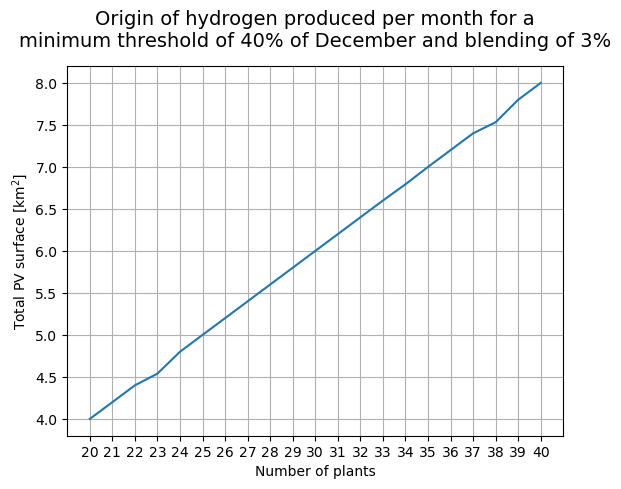

In [86]:
currentCase = df_plants[(df_plants["perc"] == 0.4) &
                            (df_plants['m'] == 12) &
                            (df_plants['b'] == 0.03)]
    
# ----------------- GET THE DATA -----------------
    
area = [sum(a) / 1e6 for a in currentCase['Area'].values]

plt.plot(range(20, 41), area)

# Adding labels and title
plt.xlabel('Number of plants')
plt.ylabel('Total PV surface [km$^2$]')

plt.title("Origin of hydrogen produced per month for a\nminimum threshold of 40% of December and blending of 3%", y=1.03, fontsize=14)

plt.xticks(range(20, 41))

plt.grid()

plt.savefig("project_data/out/Images/08_05_02_pv_area.png", transparent = True, dpi = 300, bbox_inches='tight')

# Hydrogen cost origin

In this part we will explore the main factors affecting the price of hydrogen. In this part a single scenario will be considered :

| **perc** |     **m**    | **b** | **n** |
|:--------:|:------------:|:-----:|:-----:|
|    40%   |12 (December) |   3%  |   20  |

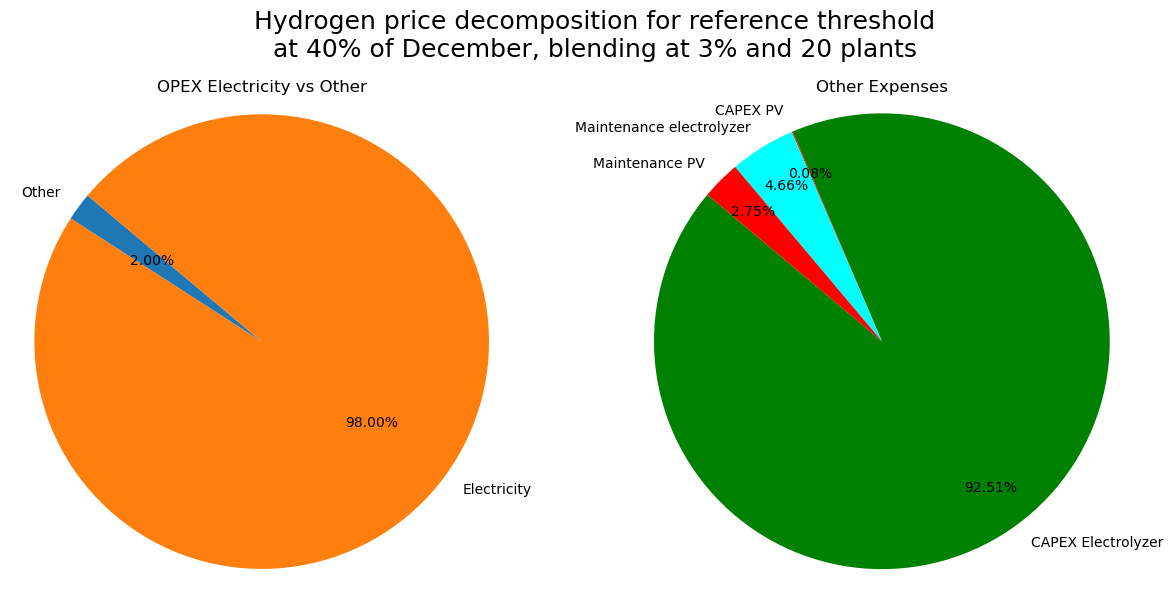

In [102]:
# ============== FILTER ==============

n = 20

currentCase = df_plants[(df_plants["perc"] == 0.4) &
                        (df_plants['m'] == 12) &
                        (df_plants['b'] == 0.03)]
    
currentCase = currentCase[currentCase['n'] == n]

locations = currentCase['locations'].values[0]

OPEX = currentCase['OPEX'].values[0]
CAPEX = currentCase['CAPEX'].values[0]

area = currentCase['Area'].values[0]

production = []
for i in range(n):
    production.append([list(currentCase[f'production {t}'].values[0])[i] for t in range(1, 13)])

# ============== VARIABLES ==============

tau = annualization()

A_PV = 1.52
b_PV = 1

c_mant = 3.84
c_elec = 0.08

etaPV = 0.1
ref_irr = 1.38 # reference solar irradiation (the power that the surface of the Earth receives) kW/m2

etaH2  = 0.7
HHV_H2 = 33.33

# ============== PRICE CALCULATION ==============

TOTEX = sum(OPEX) + sum(CAPEX)

# ============== CAPEX & OPEX CALCULATIONS ==============

CAPEX_PV = 0
CAPEX_H2 = 0

OPEX_maint_H2 = 0
OPEX_maint_PV = 0

OPEX_elec = 0

for i in range(n):
    Pinst = etaPV * ref_irr * area[i] # kWe Electric power installed
    
    # ---------- CAPEX CALCULATIONS ----------
    
    CAPEX_PV += tau * A_PV * Pinst**b_PV 
    CAPEX_H2 += CAPEX[i] - CAPEX_PV
    
    # ---------- OPEX CALCULATIONS ----------
    
    OPEX_maint_H2 += (CAPEX[i] - tau * A_PV * Pinst**b_PV) * 0.05
    OPEX_maint_PV += c_mant * Pinst
    
    _, _, P_elec_t, _ = computeMonthlyOPEX(locations[i], area[i], production[i], CAPEX[i])
    
    OPEX_elec += c_elec * sum(P_elec_t)


# ============== PIE CHART ==============

# ---------- DATA PREPARATIONS ----------

sizes = [CAPEX_H2, CAPEX_PV, OPEX_maint_H2, OPEX_maint_PV, OPEX_elec]
labels = ["CAPEX Electrolyzer", "CAPEX PV", "Maintenance electrolyzer", "Maintenance PV", "Electricity"]

opex_elec_percentage = OPEX_elec / TOTEX
other_percentage = 1 - opex_elec_percentage

sizes_split = [other_percentage, opex_elec_percentage]
labels_split = ['Other', 'Electricity']

# ---------- FIRST PLOT ----------

plt.figure(figsize=(12, 6))

plt.suptitle(f"Hydrogen price decomposition for reference threshold\nat 40% of December, blending at 3% and {n} plants", fontsize = 18)

plt.subplot(1, 2, 1)
plt.pie(sizes_split, labels=labels_split, autopct=lambda p:f'{p:.2f}%', startangle=140)
plt.axis('equal')
plt.title('OPEX Electricity vs Other')

# ---------- SECOND PLOT ----------

plt.subplot(1, 2, 2)

sizes_other = sizes[:-1]  # Exclude OPEX_elec
labels_other = labels[:-1]
plt.pie(sizes_other, labels=labels_other, autopct=lambda p:f'{p:.2f}%', pctdistance=0.8, startangle=140, colors=['g', 'red', 'cyan', 'red'])
plt.axis('equal')
plt.title('Other Expenses')

plt.tight_layout()


plt.savefig("project_data/out/Images/08_05_03_hydrogen_cost_decomposition.png", transparent = True, dpi = 300, bbox_inches='tight')

## Production as a function of blending

As the percentage of blending increases, the CAPEX will two, but how ?

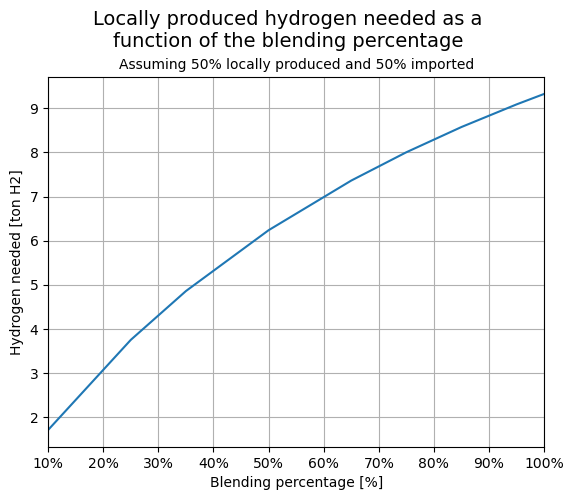

In [7]:
blendings = [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]

Y = []

for b in blendings:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minTOTEX.json") as file:
        data = json.load(file)
        
        plantsCosts = data["capacity"]
        Y.append(max([sum(a) / 1e6 for a in plantsCosts if len(a) > 0]))

plt.plot(blendings, Y)

def percent_formatter(x, pos):
    return f"{x * 100:.0f}%"

plt.xlim([0.1, 1])
plt.xticks(np.linspace(0.1, 1, 10))

formatter = FuncFormatter(percent_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.suptitle("Locally produced hydrogen needed as a\nfunction of the blending percentage", y=1.02, fontsize=14)
plt.title('Assuming 50% locally produced and 50% imported', fontsize=10)

plt.ylabel("Hydrogen needed [ton H2]")
plt.xlabel("Blending percentage [%]")

plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/production.png", transparent = True, dpi = 300, bbox_inches='tight')

## 

## Number of districts served

In here, we can see the minimum and maximum number of districts the plants serve.

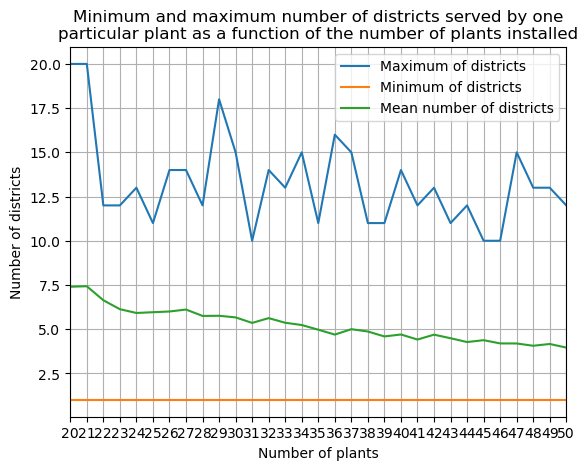

In [30]:
Ymin = []
Ymax = []
Ymean = []

plantsServing = []

b = 0.75
#for b in [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]:
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minTOTEX.json") as file:
    data = json.load(file)
    plantsServing = data["servings"]

X = [len(a) for a in plantsServing if len(a) > 0]

for i in plantsServing:
    if (len(i)) == 0: continue
    
    Ymin.append(min([len(a) for a in i]))
    Ymax.append(max([len(a) for a in i]))
    Ymean.append(np.mean([len(a) for a in i]))

plt.plot(X, Ymax, label = "Maximum of districts")
plt.plot(X, Ymin, label = "Minimum of districts")
plt.plot(X, Ymean, label = "Mean number of districts")

plt.xlabel("Number of plants")
plt.ylabel("Number of districts")
plt.title("Minimum and maximum number of districts served by one\nparticular plant as a function of the number of plants installed")

plt.xlim([min(X), max(X)])
plt.xticks(np.arange(min(X), max(X) + 1, step=1))

plt.legend()
plt.grid()

## Total number of districts

Total number of districts served by n plants

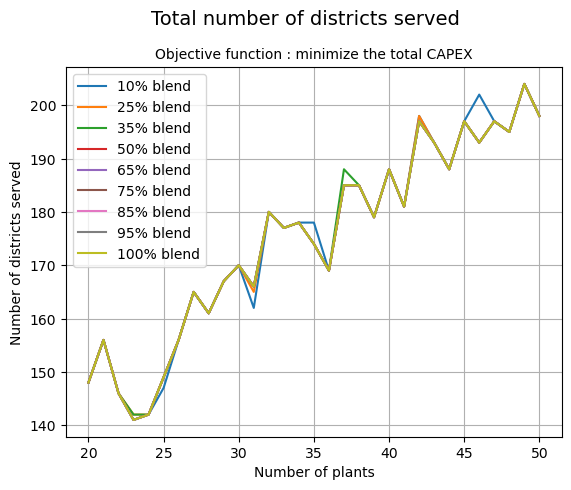

In [31]:
for b in [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]:
    with open(f"project_data/out/reducedDemand/optimalPlaces_reduced{b}_minTOTEX.json") as file:
        data = json.load(file)
        plantsServing = data["servings"]
    
    X = [len(a) for a in plantsServing if len(a) > 0]
    Y = []
    for a in plantsServing:
        if (len(a) == 0): continue
        
        Y.append(sum([len(i) for i in a]))
    
    plt.plot(X,Y, label = str(int(100*b)) + "% blend")

plt.suptitle("Total number of districts served", y=1, fontsize=14)
plt.title('Objective function : minimize the total CAPEX', fontsize=10)

plt.xlabel("Number of plants")
plt.ylabel("Number of districts served")

#plt.xlim([2, 20])
#plt.xticks(np.arange(2, 21, 1))

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/districts_minCAPEX.png", dpi = 300, transparent = True)

## Distance from plants

In this following graph we can see the mean, standard deviation, minimum and maximum distance for each of the clusters.

In [ ]:
b = 1
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
    currentCase = json.load(file)
    
    plantsServings = currentCase["servings"]
    plantsSpecifications = currentCase["specifications"]
    plantsLocations = currentCase["locations"]

totDistance = []

meanDistance = []
stdDistance = []

avgDistance = []

minDistance = []
maxDistance = []

X = [len(a) for a in plantsServings if len(a) > 0]

for i, cluster in enumerate(plantsServings): # For each number of plants n : 2 -> 20
    if (len(cluster) == 0): continue
    
    _, hydrogenDemand, _, _ = computeHydrogenDemand(b)
    
    mn  = 0
    avg = 0
    
    lengths = [] # Lenghts
    demd = []    # Demand
    
    for j, servs in enumerate(cluster): # For each plant in the n plants
        for serv in servs: # Add the length of all the places it serves
            lengths.append(getDistancePath(Connections[plantsLocations[i][j]][serv]))
            demd.append(hydrogenDemand.loc[serv]['value'])
    
    totDistance.append(sum(lengths))
    
    lengths = np.array(lengths)
    
    meanDistance.append(np.mean(lengths))
    stdDistance.append(np.std(lengths))
    
    avgDistance.append(np.average(lengths, weights = demd)) # Compute the avg by weighting with the H2 demand

    minDistance.append(min(lengths))
    maxDistance.append(max(lengths))
    
plt.plot(X, meanDistance, label = "Mean distance")
plt.plot(X, stdDistance, label = "Standard deviation of distance")

plt.plot(X, avgDistance, label = "Avg")

plt.plot(X, minDistance, label = "Minimum distance")
plt.plot(X, maxDistance, label = "Maximum distance")

plt.xlabel("Number of plants")
plt.ylabel("Distance [km]")
plt.title("Different distances as a function of the number of plants installed")

plt.legend()
plt.grid()
plt.show()

## Total length

In [ ]:
for b in blendings:
    with open(f"project_data/out/reducedDemand/optimalPlaces_reduced{b}_minLENGTH.json", 'r') as file:
        currentCase = json.load(file)

        plantsServings = currentCase["servings"]
        plantsSpecifications = currentCase["capacity"]
        plantsLocations = currentCase["locations"]

    totDistance = []

    X = [len(a) for a in plantsServings if len(a) > 0]

    for i, cluster in enumerate(plantsServings): # For each number of plants n : 2 -> 20
        if (len(cluster) == 0): continue

        lengths = [] # Lenghts
        
        for j, servs in enumerate(cluster): # For each plant in the n plants
            for serv in servs: # Add the length of all the places it serves
                lengths.append(getDistancePath(Connections[plantsLocations[i][j]][serv]))
                demd.append(hydrogenDemand.loc[serv, 'value'])

        totDistance.append(sum(lengths))

    plt.plot(X, totDistance, label = str(int(100*b)) + "% blend")

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, 1))

plt.suptitle("Total pipe distance as a function of\nthe number of plants and blending percentage", y=1.02, fontsize=14)
plt.title('Objective function : minimize the total pipe length', fontsize=10)

plt.xlabel("Number of plants")
plt.ylabel("Total pipe distance [km]")

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/length_minLENGTH.png", dpi = 300, transparent = True, bbox_inches = 'tight')

# THE FORBIDDEN PIT OF CODE

Here I just put all the code that is no longer useful or were I test things and don't know where to place

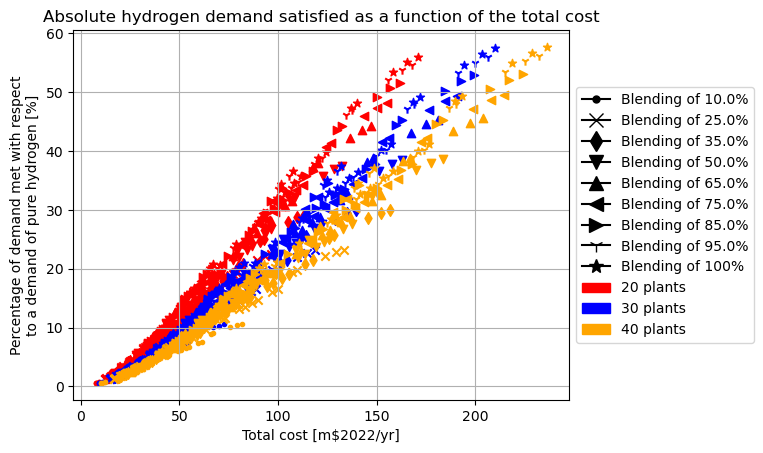

In [463]:
marker_dict = {val: markers[i] for i, val in enumerate(b_values)}
clusters = [20, 30, 40]

_, ref_demand, _, _, _ = computeHydrogenDemand(1, industry=False)

for index_n, n in enumerate(clusters):
    currentCase = df_plants[df_plants['n'] == n]
    
    b = currentCase['b'].values
    
    totCAPEX = currentCase["CAPEX"].values
    totOPEX  = currentCase["OPEX"].values
    TOTEX = [(sum(totCAPEX[i]) + sum(totOPEX[i])) / 1e6 for i in range(len(totCAPEX))]
    
    production = []
    for index, row in currentCase.iterrows():
        production.append([row[f"production {t}"] for t in range(1, 13)])
    
    demand = []
    for prod in production:
        _, d = computeDemandMet(ref_demand, prod)
        demand.append(100 * d)
    
    # Assign markers based on b values
    assigned_markers = [marker_dict[val] for val in b]
    
    for i in range(len(TOTEX)):
        plt.scatter(TOTEX[i], demand[i], c=colors[index_n], marker=assigned_markers[i])

handles = []
# Create the custom legend
for b, marker in marker_dict.items(): # Shapes
    marker_handle = mlines.Line2D([], [], color='black', marker=marker, markersize=10, label=f"Blending of {100*b}%")
    handles.append(marker_handle)

for i, n in enumerate(clusters): # Colors
    color_patch = mpatches.Patch(color=colors[i], label=f"{n} plants")
    handles.append(color_patch)

plt.title("Absolute hydrogen demand satisfied as a function of the total cost")
plt.xlabel("Total cost [m$2022/yr]")
plt.ylabel("Percentage of demand met with respect\nto a demand of pure hydrogen [%]")

plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

In [27]:
area = 244558318.949272
OPEX = 183616188.58910635
CAPEX = 10484060.567711573
location = "DE145"
production = [255755.534532666, 267066.0918905026, 187519.35750836116, 134971.70034822205, 70331.12085771956, 55097.683147656215, 51942.96847623218, 52673.95408479655, 68073.61056380902, 128334.13479628104, 204300.26066998398, 241516.30581144028]


c_elec = [0.044] * 12
c_mant = 3.84 / 12
etaH2 = 0.7
etaPV = 0.1
HHV_H2 = 33.33  # kWh/kgH2

ref_irr = 1.38 # reference solar irradiation (the power that the surface of the Earth receives) kW/m2
mean = list(solar_irr[solar_irr["nuts3"] == location]["mean_irr"].values)[0]

Pinst = etaPV * ref_irr * area # kWe Electric power installed
Pmonthly = [production[t] * daysMonth[t] * HHV_H2 / etaH2 for t in range(12)] # The power consumption in kWhp/month

OPEX_t = [0] * 12

# ----------------- CORRECT THE CAPEX -----------------

tau = annualization() # - return on investment

CAPEX_PV = tau * A_PV * Pinst**b_PV 
CAPEX_H2 = CAPEX - CAPEX_PV 

# ----------------- COMPUTE THE OPEX -----------------

OPEX_plants = CAPEX_H2 * 0.05 / 12 # The maintenance and operation cost of running the electrolyzers

OPEX_PV = [( c_elec[t] * max(Pmonthly[t] - mean[t] * area * etaPV, 0) ) + c_mant * Pinst for t in range(12)]    # OPerational costs

OPEX_t = [pv + OPEX_plants for pv in OPEX_PV]

#OPEX_t, _, _, _ = computeMonthlyOPEX(loc, A, prod, CAPEX)

maxArea = min(max(Pmonthly) / ref_irr / etaPV / 2, 2e5)    # m2 The maximum PV area. It is equal to the most needed area, or 20 ha
Areas = np.arange(0, maxArea, maxArea / 1e4)               # m2

tau = annualization() # - return on investment

OPEX_A  = []
CAPEX_A = []
TOTEX_A = []

for A in Areas:
    Pinst = etaPV * ref_irr * A # kWe Electric power installed
    
    OPEX_t = [( c_elec[t] * max(Pmonthly[t] - mean[t] * A * etaPV, 0) ) + c_mant * Pinst for t in range(12)]    # OPerational costs
    CAPEX = tau * A_PV * Pinst**b_PV                                                                            # CAPital costs of PV
    
    OPEX = sum(OPEX_t) + 0.05 * CAPEX_H2
    
    OPEX_A.append(OPEX)
    CAPEX_A.append(CAPEX)
    TOTEX_A.append(OPEX + CAPEX)

print("Only electricity", c_elec[0] * sum(production) * HHV_H2 / etaH2 / sum(production))
print("Elec + H2 maint", (0.05 * CAPEX_H2 + c_elec[0] * sum(production) * HHV_H2 / etaH2) / sum(production))
print("Elec + H2 maint + PV maint", (c_mant * Pinst + 0.05 * CAPEX_H2 + c_elec[0] * sum(production) * HHV_H2 / etaH2) / sum(production))

plt.plot(Areas, OPEX_A)
#plt.semilogy(Areas, CAPEX_H2 * np.ones(len(Areas)))
plt.grid()

NameError: name 'A_PV' is not defined

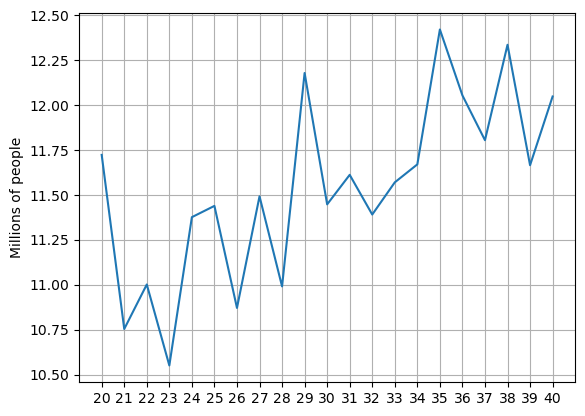

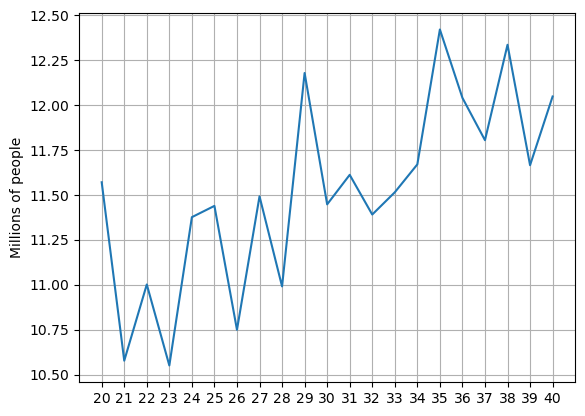

In [44]:
# ============================= POPULATION FOR perc = 0.5 =============================

currentCase = df_plants[(df_plants["perc"] == 0.5) &
                        (df_plants['m'] == 2) &
                        (df_plants['b'] == 0.5)]

# ----------------- GET THE DATA -----------------

n = currentCase['n'].values

servings = currentCase['servings'].values

# ----------------- COMPUTE THE POPULATION PER CLUSTER OF PLANTS -----------------

pop = []
for s in servings: # For each cluster of n plants
    pop.append(computeReachablePopulation(s) / 1e6)

# ----------------- PLOT -----------------

plt.plot(n, pop)

# ----------------- TITLES -----------------

plt.title("")
plt.xlabel("")
plt.ylabel("Millions of people")

plt.xticks(np.arange(20, 41))

plt.grid()
plt.show()


# ============================= POPULATION FOR perc = 0.3 =============================

plt.subplots()

currentCase = df_plants[(df_plants["perc"] == 0.3) &
                        (df_plants['m'] == 2) &
                        (df_plants['b'] == 0.5)]

# ----------------- GET THE DATA -----------------

n = currentCase['n'].values

servings = currentCase['servings'].values

# ----------------- COMPUTE THE POPULATION PER CLUSTER OF PLANTS -----------------

pop = []
for s in servings: # For each cluster of n plants
    pop.append(computeReachablePopulation(s) / 1e6)

# ----------------- PLOT -----------------

plt.plot(n, pop)

# ----------------- TITLES -----------------

plt.title("")
plt.xlabel("")
plt.ylabel("Millions of people")

plt.xticks(np.arange(20, 41))

plt.grid()
plt.show()

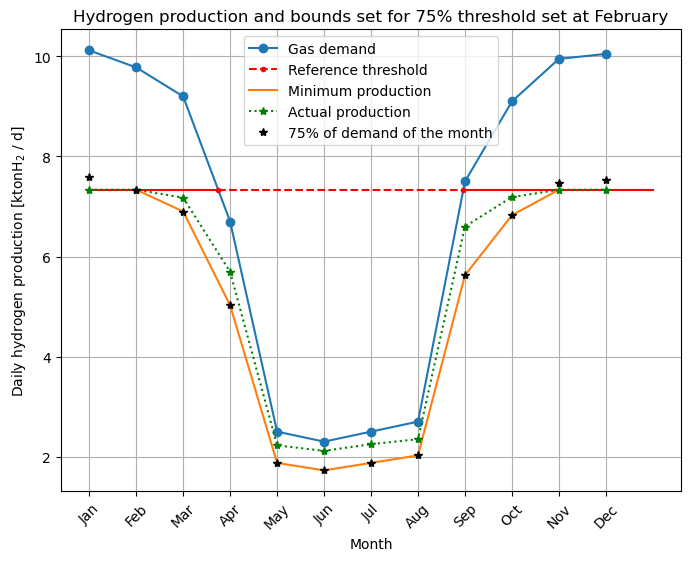

In [94]:
import matplotlib.pyplot as plt # THIS PLOT WAS MADE FOR THE REPORT

values = [10.12, 9.78, 9.2, 6.7, 2.5, 2.3, 2.5, 2.7, 7.5, 9.1, 9.95, 10.05]

# Creating the plot
plt.figure(figsize=(8, 6))
plt.plot(range(12), values, 'o-', label="Gas demand")

threshold = 0.75 * 9.78
redline1 = [0, 2.75]
redline2 = [7.95, 12]
redline3 = [2.75, 7.95]
plt.plot(redline1, [threshold] * 2, 'r-')
plt.plot(redline2, [threshold] * 2, 'r-')
plt.plot(redline3, [threshold] * 2, 'r.--', label="Reference threshold")

plt.plot(range(1, 11), [0.75 * values[i] for i in range(1, 10)] + [threshold], label = "Minimum production")

he = [0.725, 0.75, 0.78, 0.85, 0.89, 0.92, 0.9, 0.87, 0.88, 0.79, 0.737, 0.73]
plt.plot(range(12), [values[i] * he[i] for i in range(12)], 'g*:', label = "Actual production")

plt.plot(range(12), [0.75 * a for a in values], 'k*', label='75% of demand of the month')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Daily hydrogen production [ktonH$_2$ / d]')
plt.title('Hydrogen production and bounds set for 75% threshold set at February')

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(range(12), months, rotation = 45) 

# Displaying the plot
plt.legend()
plt.grid()

plt.savefig("project_data/out/Images/07_06_02_threshold.png", transparent = True, dpi = 300, bbox_inches='tight')